In [1160]:
import matplotlib.pyplot as plt
%matplotlib notebook
plt.ioff()
from skimage import io
from skimage.draw import disk, circle_perimeter
import pandas as pd
import numpy as np
from os import path

In [1161]:
base_path = "/media/ula/DATADRIVE1/fos_gfp_tmaze/ctx_landmark/despeckle/"
res_dir_path = base_path + "alignment_result/"
dir_path = res_dir_path + "aligned_despeckle/"
cell_data_fn_template = "m{}r{}_{}_output.txt"
img_fn_template = "m{}r{}_{}.tif"
excel_path = "/home/ula/twophoton/summary.xlsx"
excel_sheet_name = "summary"


In [1162]:
behav_df = pd.read_excel(excel_path, excel_sheet_name)
behav_df.set_index("mouse")

,first_cue_exposure,landmark_1st_entry,landmark_avg,ctx_1st_entry,ctx_avg,last_training,first_training,performance diff,retrieval_landmark,retrieval_ctx
mouse,,,,,,,,,,
9,landmark,82,82,46,53,76,68,29,58,60
11,ctx,96,98,74,74,88,56,24,78,56
6,landmark,90,90,66,67,96,54,23,72,50
19,ctx,82,86,64,64,94,46,22,60,52
13,ctx,90,91,70,70,92,50,21,66,58
1,landmark,86,86,70,69,88,54,17,54,70
20,ctx,94,90,74,74,84,46,16,74,54
7,landmark,84,84,68,69,80,54,15,52,50
3,landmark,80,80,64,66,82,54,14,64,48


In [4]:
xcolname = "Intensity center X (px) (ch 0)"
ycolname = "Intensity center Y (px) (ch 0)"
zcolname = "Intensity center Z (px) (ch 0)"

In [1212]:
all_rois = np.array([(1,1,'l'), (1,2,'l'), 
                    (2,1,'c'), (2,2,'c'), 
                    (3,1,'l'), (3,2,'l'), 
                    (4,1,'l'), (4,2,'l'), 
                    (5,1,'c'), (5,2,'c'), (5,3,'c'), 
                    (6,1,'l'), (6,2,'l'), 
                    (7,1,'l'), (7,2,'l'), (7,3,'l'), 
                    (8,1,'c'), (8,2,'c'), 
                    #(9,1,'l'), (9,2,'l'),
                   (10,1,'c'), (10,2,'c'), (10,3,'c'), 
                    (11,1,'c'), (11,2,'c'), (11,3,'c'), 
                    (12,1,'l'), (12,2,'l'), (12,3,'l'),
                   (13,1,'c'), (13,2,'c'), (13,3,'c'),
                   (14,1,'c'), (14,2,'c'), (14,3,'c'), (14,4,'c'),
                   (15,1,'l'), (15,2,'l'), (15,3,'l'),
                   (16,1,'c'), (16,2,'c'),
                   (17,1,'l'), (17,2,'l'),
                   (18,1,'l'), (18,2,'l'),
                   #(19,1,'c'), (19,2,'c'),
                   (20,1,'c'), (20,2,'c'), (20,3,'c')
])

In [1177]:
cll_pairs = np.array([(2,1), (2,2), (5,1), (5,2), (5,3),(8,1), (8,2),
                     (10,1), (10,2), (10,3), (11,1), (11,2), (11,3), 
                     (13,1), (13,2), (13,3), (14,1), (14,2), (14,3), 
                      (14,4), (16,1), (16,2),#(19,1), (19,2),
                     (20,1), (20,2), (20,3)])
lcc_pairs = np.array([(1,1), (1,2), (3,1), (3,2), (17,1), (17,2), 
                      (12,1),(12,2), (12,3), (15,1), #(9,1), (9,2), 
             (15,2), (15,3), (18,1), (18,2), (4,1), (4,2), (6,1), (6,2)])

In [1140]:
min_interior = 30
sessions={
'l' : ["landmark", "ctx1", "ctx2"],
'c' : ["ctx", "landmark1", "landmark2"]}

In [1141]:
roi_diameter = [8,7,4]
xy_scale = 1.19;
z_scale = 2;
tolerance = 4

In [1142]:
landmark_first_mice = [1, 3, 4, 6,7,9,12,15,17, 18]
landmark_first_mice = []
ctx_first_mice = [2,5,8,10,11,13,14,16,19,20]
ctx_first_mice = [5,10,11]
ctx_session_order = ["ctx", "landmark1", "landmark2"]
landmark_session_order = ["landmark", "ctx1", "ctx2"]

max_region_no = 4

In [27]:
def calculate_intensity(center_x, center_y, center_z, img):
    center_x = int(round(center_x))
    center_y = int(round(center_y))
    center_z = int(round(center_z))
    sum_int = 0
    area_int = 0
    for i in range(-2,3):
        if(center_z+i >= 0 and center_z+i < img.shape[0]):
            diameter = roi_diameter[abs(i)]
            rad = diameter//2
            disk_ = disk((center_y, center_x), rad, shape=img[0].shape)
            sum_int += np.sum(img[center_z+i][disk_])
            area_int += len(img[center_z+i][disk_])
    if area_int == 0:
        print(center_x, center_y, center_z)
        return 0
    return sum_int/area_int

In [28]:
def update_intensity_for_df(df, img):
    df["intensity_standarized"] = df.apply(lambda row : calculate_intensity(row[xcolname],
                     row[ycolname], row[zcolname], img), axis = 1)
    return df[df['Mean Intensity (ch 0)']/df['intensity_standarized']<=1.5]

In [29]:
def rescale_df(df):
    df[xcolname] = df[xcolname]*xy_scale
    df[ycolname] = df[ycolname]*xy_scale
    df[zcolname] = df[zcolname]*z_scale
    return df

In [30]:
def calculate_overlap(df1, df2):
    res_df = pd.DataFrame(columns=["idx1", "idx2", "intensity1", "intensity2"])
    multiple_algs = 0
    for idx1, row1 in df1.iterrows():
        rep_counter = 0
        for idx2, row2 in df2.iterrows():
            dist = np.linalg.norm(row1[xcolname:zcolname]-row2[xcolname:zcolname])
            if dist < tolerance:
                rep_counter += 1
                if rep_counter == 2:
                    multiple_algs+=1
                elif rep_counter == 1:
                    res_df = res_df.append({"idx1":idx1, "idx2" :idx2, 
                                            "intensity1":row1['intensity_standarized'], 
                                            "intensity2":row2['intensity_standarized']},
                                           ignore_index=True)
    return res_df

In [31]:
def find_fluorescence_profile(row, bgrs):
    row_i0 = row.i0 - bgrs[0]
    row_i1 = row.i1 - bgrs[1]
    row_i2 = row.i2 - bgrs[2]

    if row_i0 > row_i1 and row_i0 > row_i2:
        return 'a'
    elif row_i0 < row_i1 and row_i0 < row_i2:
        return 'b'


In [32]:
def find_persistent_cells(rdf1, rdf2, bgrs):
    persistent = rdf1.join(rdf2.set_index("idx1"), on="idx1", how="inner", rsuffix="_r")
    ordered = pd.DataFrame(columns=["i0", "i1", "i2"])
    ordered.i0 = persistent.intensity2
    ordered.i1 = persistent.intensity1
    ordered.i2 = persistent.intensity2_r
    ordered["fluo_type"] = ordered.apply(lambda row 
                                         : find_fluorescence_profile(row, bgrs), axis = 1)
    ordered.to_csv(dir_path + cell_data_fn_template.format(mouse, region, "ordered"))

In [33]:
def find_background_intensities(df_array):
    res = np.array([])
    for i in range(len(df_array)):
        df = df_array[i]
        background_cells = df[df.intensity_standarized<df.intensity_standarized.quantile(0.25)]
        #res=np.append(res, background_cells.describe().intensity_standarized['mean'])
        res=np.append(res, df.intensity_standarized.quantile(0.25))    
    return res

In [34]:
def get_bgrs(df):
    ret = np.zeros(3)
    ret[0] = df[df.i0<df.i0.quantile(0.25)].describe().i0['mean']
    ret[1] = df[df.i1<df.i1.quantile(0.25)].describe().i1['mean']
    ret[2] = df[df.i2<df.i2.quantile(0.25)].describe().i2['mean']
    df1 = df[df.i0>0]
    df2 = df[df.i1>0]
    df3 = df[df.i2>0]
    #return [df1.i0.quantile(0.1), df2.i1.quantile(0.1), df3.i2.quantile(0.1)]
    return [0,0,0]

In [35]:
def compare_sessions(mouse, region, session_order_code):
    df_array={}
    img_array={}
    session_order = sessions[session_order_code]
    for i in range(len(session_order)):
        df_array[i] = pd.read_csv(dir_path + cell_data_fn_template
                                  .format(mouse, region, session_order[i]), "\t", header=1)
        img_array[i] =  io.imread(dir_path + img_fn_template
                                  .format(mouse, region, session_order[i])).astype("uint8")
        
    for i in range(len(session_order)):
        df_array[i] = df_array[i][df_array[i]['Interior (px)']>30]
        df_array[i] = update_intensity_for_df(df_array[i], img_array[i])
        df_array[i] = rescale_df( df_array[i])
        
    bgrs = find_background_intensities(df_array)
    #tutaj b wazna kolejnosc!!!   
    rdf1 = calculate_overlap(df_array[1], df_array[0])  
    rdf1.to_csv(dir_path + cell_data_fn_template
                .format(mouse, region, session_order[1]+"_"+session_order[0]))
    rdf2 = calculate_overlap(df_array[1], df_array[2])
    rdf2.to_csv(dir_path + cell_data_fn_template
                .format(mouse, region, session_order[1]+"_"+session_order[2]))
    find_persistent_cells(rdf1, rdf2, bgrs)
    return rdf1, rdf2


In [36]:
ftypes = ['a', 'b', 'c']


In [37]:
def calc_subset_sizes(mouse, region, session_order_code):
    df_array={}
    img_array={}
    session_order = sessions[session_order_code]
    for i in range(len(session_order)):
        df_array[i] = pd.read_csv(dir_path + cell_data_fn_template
                                  .format(mouse, region, session_order[i]), "\t", header=1)
        img_array[i] =  io.imread(dir_path + img_fn_template
                                  .format(mouse, region, session_order[i])).astype("uint8")
        
    for i in range(len(session_order)):
        df_array[i] = df_array[i][df_array[i]['Interior (px)']>30]
        df_array[i] = update_intensity_for_df(df_array[i], img_array[i])
    rdf1 = (pd.read_csv(dir_path + cell_data_fn_template
                .format(mouse, region, 
                        session_order[1]+"_"+session_order[0]))).drop_duplicates(subset='idx2') 
    rdf2 = (pd.read_csv(dir_path + cell_data_fn_template
                .format(mouse, region, 
                        session_order[1]+"_"+session_order[2]))).drop_duplicates(subset='idx2') 
    rdf3 = (pd.read_csv(dir_path + cell_data_fn_template
                .format(mouse, region, 
                        session_order[0]+"_"+session_order[2]))).drop_duplicates(subset='idx2') 
    
    persistent = pd.read_csv(dir_path + cell_data_fn_template.format(mouse, region, "ordered"))

    return np.array([df_array[0].shape[0], 
                         df_array[1].shape[0], 
                         df_array[2].shape[0], 
                         rdf1.shape[0], 
                         rdf2.shape[0],  
                         rdf3.shape[0], 
                         persistent.shape[0]])
    

In [39]:
ret1 = np.empty((cll_pairs.shape[0], 7))
print(ret1.shape)
idx = 0
for m, r in cll_pairs:
    if int(m) != 19 and int(m) != 9:
        ret1[idx] = calc_subset_sizes(m,r,'c')
        idx+=1

(25, 7)


In [900]:
ret2

array([[1618., 1778., 1652., 1135.,  706.,  827.,  488.],
       [2040., 2284., 2180., 1492., 1502., 1274., 1089.],
       [2443., 2471., 2427., 1327., 1416., 1628., 1019.],
       [2263., 2256., 2212.,  944., 1283., 1144.,  692.],
       [2331., 2448., 2362., 1713., 1453., 1562., 1147.],
       [2445., 2674., 2579., 1894., 1901., 1841., 1539.],
       [2604., 2569., 2686., 1696., 1659., 1644., 1266.],
       [2660., 2865., 3013., 1714., 1558., 1568., 1089.],
       [1657., 1697., 1736.,  958.,  949.,  896.,  662.],
       [1087., 1040., 1151.,  687.,  713.,  685.,  529.],
       [1693., 1691., 1790., 1243., 1180., 1279.,  982.],
       [2103., 2114., 2188., 1302., 1341., 1560., 1049.],
       [ 842.,  970.,  964.,  455.,  493.,  528.,  300.],
       [1249., 1336., 1232.,  656.,  682.,  619.,  382.],
       [1448., 1396., 1428.,  937.,  976., 1001.,  764.],
       [1398., 1466., 1538., 1010., 1037., 1048.,  823.],
       [ 600.,  638.,  638.,  338.,  480.,  430.,  287.],
       [1360.,

In [41]:
ret2 = np.empty((lcc_pairs.shape[0], 7))
idx = 0
for m, r in lcc_pairs:
    if int(m) != 19 and int(m) != 9:
        ret2[idx] = calc_subset_sizes(m,r,'l')
        idx+=1

1 1 0
1 1 0
1 2 1
1 2 1
3 1 2
3 1 2
3 2 3
3 2 3
17 1 4
17 1 4
17 2 5
17 2 5
12 1 6
12 1 6
12 2 7
12 2 7
12 3 8
12 3 8
15 1 9
15 1 9
15 2 10
15 2 10
15 3 11
15 3 11
18 1 12
18 1 12
18 2 13
18 2 13
4 1 14
4 1 14
4 2 15
4 2 15
6 1 16
6 1 16
6 2 17
6 2 17


<IPython.core.display.Javascript object>


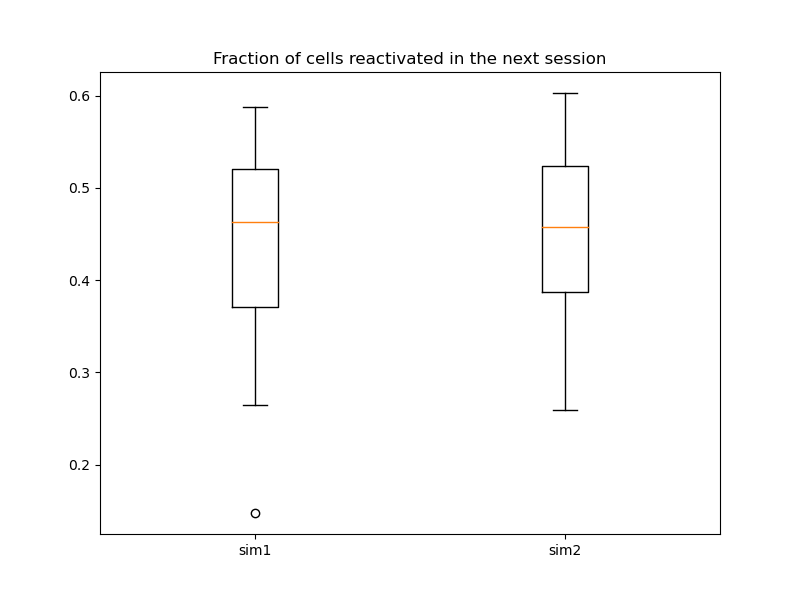

In [697]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.boxplot([ret2[:,3]/(ret2[:,0]+ret2[:,1]-ret2[:,3]),
            ret2[:,4]/(ret2[:,1]+ret2[:,2]-ret2[:,4])])
ax.set_xticklabels(['sim1', 'sim2'])
plt.title("Fraction of cells reactivated in the next session")
plt.show()

<IPython.core.display.Javascript object>


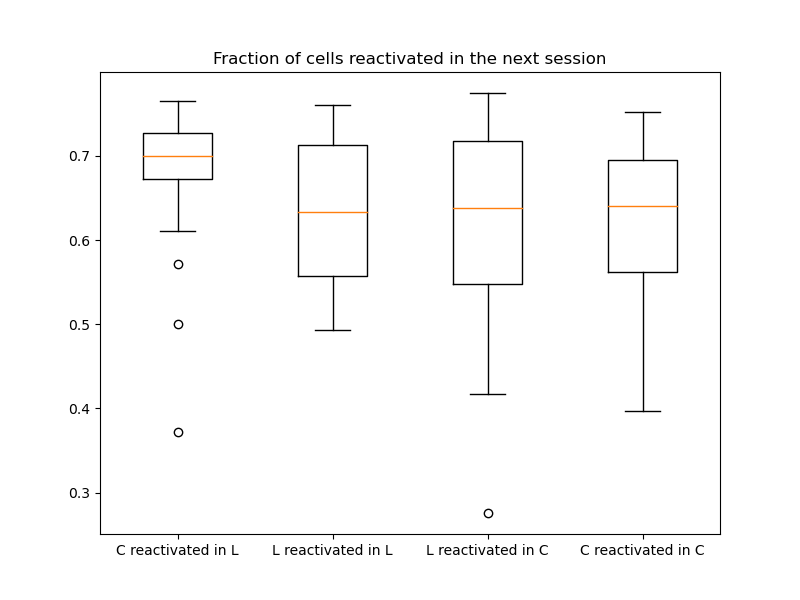

In [90]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.boxplot([ret1[:,3]/ret1[:,0],ret1[:,4]/ret1[:,1],
             ret2[:,3]/ret2[:,0],ret2[:,4]/ret2[:,1],])
ax.set_xticklabels(['C reactivated in L','L reactivated in L', 
                    'L reactivated in C','C reactivated in C'])
plt.title("Fraction of cells reactivated in the next session")
plt.show()

In [83]:
np.sum(ret1[:,3])

31627.0

<IPython.core.display.Javascript object>


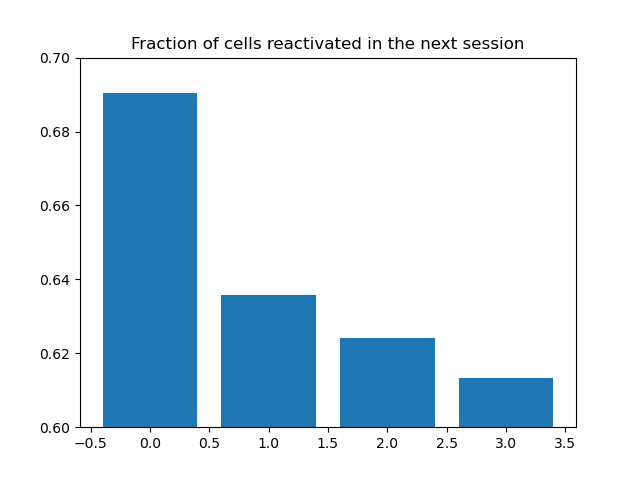

In [89]:
plt.bar([0,1,2,3],[np.sum(ret1[:,3])/np.sum(ret1[:,0]),np.sum(ret1[:,4])/np.sum(ret1[:,1]),
             np.sum(ret2[:,3])/np.sum(ret2[:,0]),np.sum(ret2[:,4]/np.sum(ret2[:,1]))])

plt.title("Fraction of cells reactivated in the next session")
plt.ylim(0.6, 0.7)
plt.show()

In [496]:
mouse_success = np.array([])
mice = np.array([])
for m, r in lcc_pairs:
    if int(m) != 19 and int(m) != 9:
        mouse_success = np.append(mouse_success, behav_df.loc[m]['performance diff'])
        mice = np.append(mice, m)

<IPython.core.display.Javascript object>


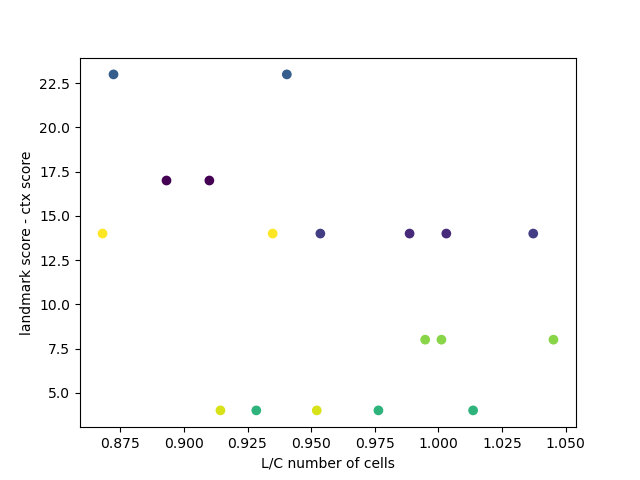

In [591]:
plt.scatter(ret2[:,0]/ret2[:,1], mouse_success, c=mice)
plt.xlabel("L/C number of cells")
plt.ylabel("landmark score - ctx score")
plt.show()

<IPython.core.display.Javascript object>


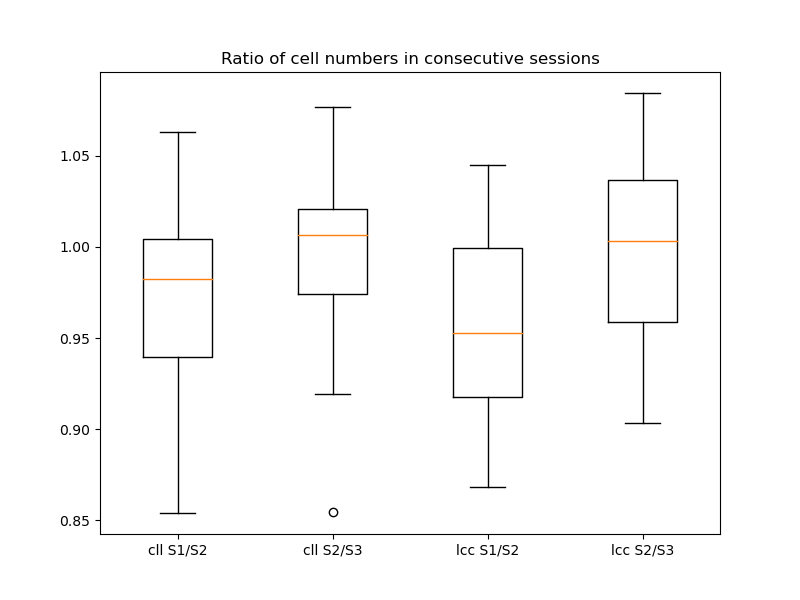

In [592]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.boxplot([ret1[:,0]/ret1[:,1],ret1[:,1]/ret1[:,2],
             ret2[:,0]/ret2[:,1],ret2[:,1]/ret2[:,2]])
ax.set_xticklabels(['cll S1/S2','cll S2/S3', 'lcc S1/S2','lcc S2/S3'])
plt.title("Ratio of cell numbers in consecutive sessions")
plt.show()

<IPython.core.display.Javascript object>


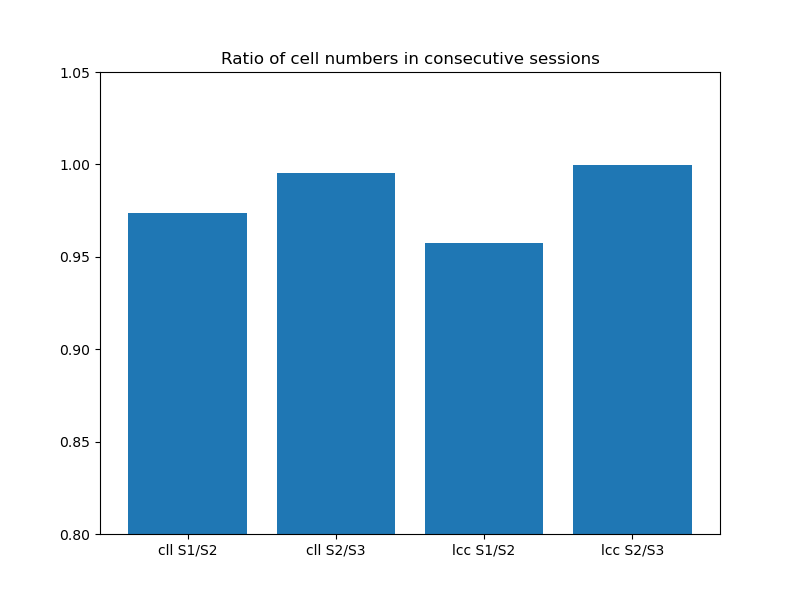

In [95]:
fig, ax = plt.subplots(figsize=(8, 6))
xticks = ['cll S1/S2','cll S2/S3', 'lcc S1/S2','lcc S2/S3']
plt.bar(xticks, [np.sum(ret1[:,0])/np.sum(ret1[:,1]),np.sum(ret1[:,1])/np.sum(ret1[:,2]),
             np.sum(ret2[:,0])/np.sum(ret2[:,1]),np.sum(ret2[:,1])/np.sum(ret2[:,2])])
plt.title("Ratio of cell numbers in consecutive sessions")
plt.ylim(0.8, 1.05)
plt.show()

<IPython.core.display.Javascript object>


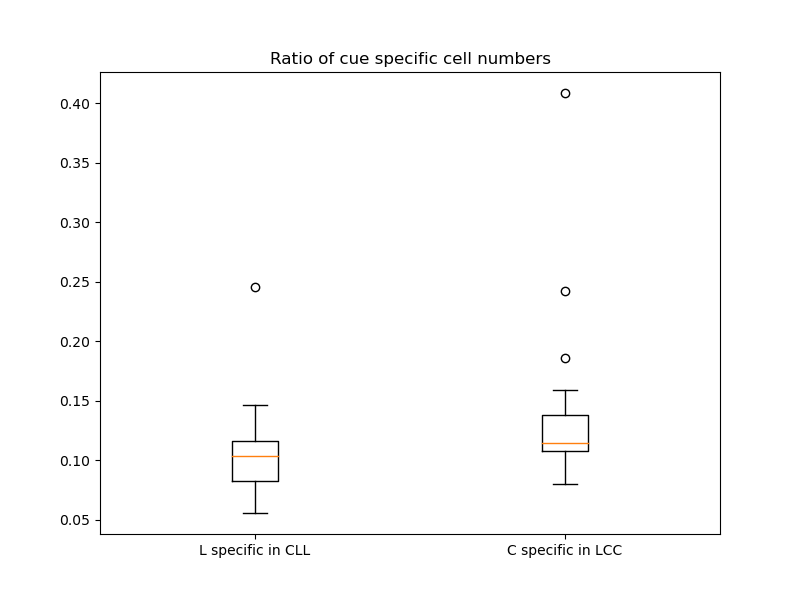

In [593]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.boxplot([(ret1[:,4]-ret1[:,6])/(ret1[:,1]+ret1[:,2]-ret1[:,4]),
             (ret2[:,4]-ret2[:,6])/(ret2[:,1]+ret2[:,2]-ret2[:,4])])
ax.set_xticklabels(['L specific in CLL', 'C specific in LCC'])
plt.title("Ratio of cue specific cell numbers")
plt.show()

<IPython.core.display.Javascript object>


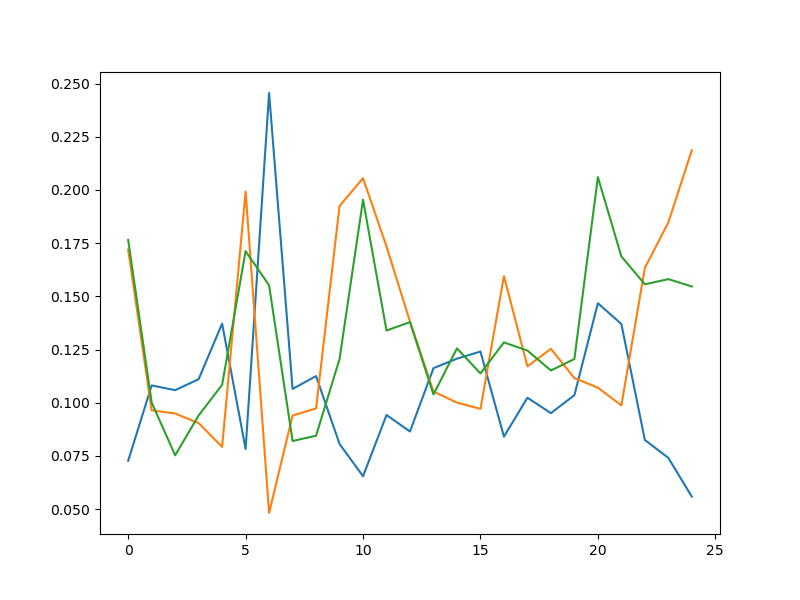

In [594]:
fig, ax = plt.subplots(figsize=(8, 6))

plt.plot((ret1[:,4]-ret1[:,6])/(ret1[:,1]+ret1[:,2]-ret1[:,4]))
plt.plot((ret1[:,3]-ret1[:,6])/(ret1[:,0]+ret1[:,1]-ret1[:,3]))
plt.plot((ret1[:,5]-ret1[:,6])/(ret1[:,0]+ret1[:,2]-ret1[:,5]))

plt.show()

<IPython.core.display.Javascript object>


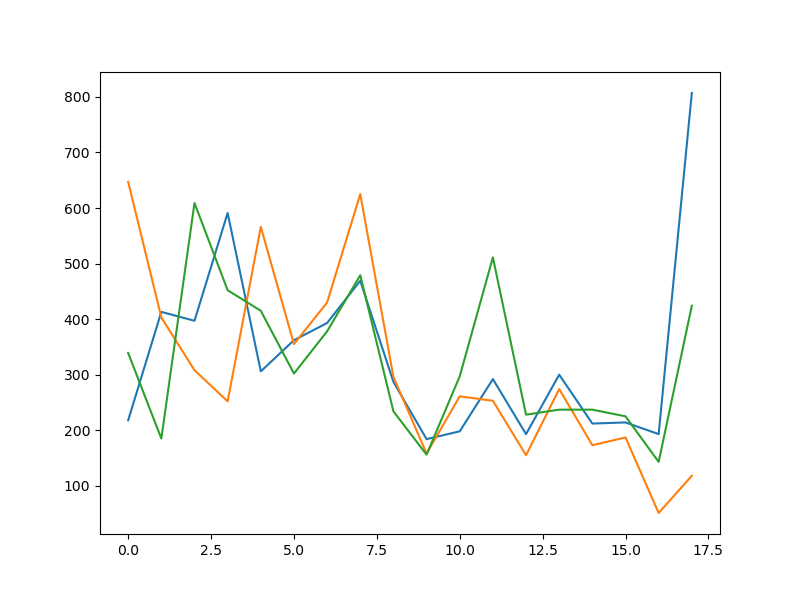

In [595]:
fig, ax = plt.subplots(figsize=(8, 6))

plt.plot(ret2[:,4]-ret2[:,6])
plt.plot(ret2[:,3]-ret2[:,6])
plt.plot(ret2[:,5]-ret2[:,6])

plt.show()

<IPython.core.display.Javascript object>


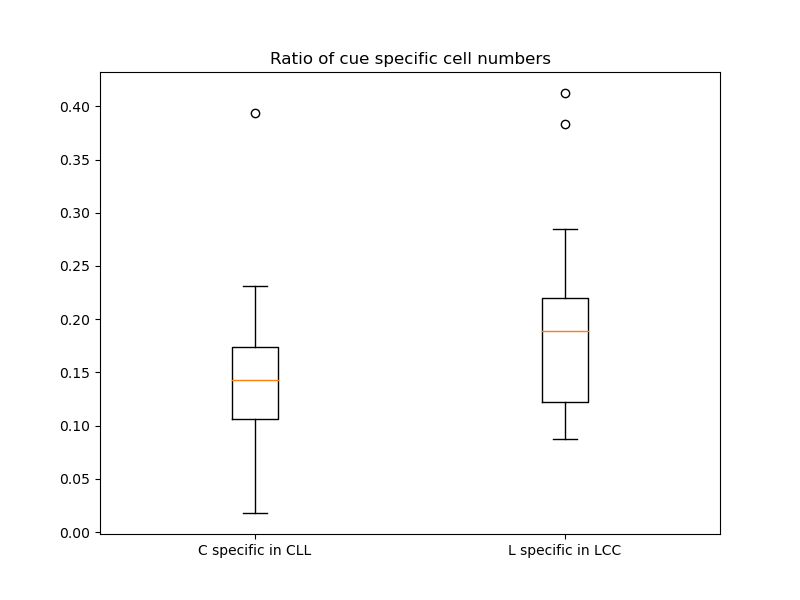

In [596]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.boxplot([(ret1[:,0]-ret1[:,3]-ret1[:,5]+ret1[:,6])/ret1[:,0],
             (ret2[:,0]-ret2[:,3]-ret2[:,5]+ret2[:,6])/ret2[:,0]])
ax.set_xticklabels(['C specific in CLL', 'L specific in LCC'])
plt.title("Ratio of cue specific cell numbers")
plt.show()

In [485]:
ret1[21]

array([1.11416848e+218, 9.45956265e-076, 1.61410559e+132, 1.42137876e-076,
       1.00385544e+218, 1.76037256e+136, 9.02193423e+217])

In [185]:
cll_pairs = np.array([(2,1), (5,1), (5,2), (10,1), (10,2), (11,1), (11,2), (19,2), (19,3), (13,2), (13,1), 
             (2,2), (5,3), (8,1), (8,2), (10,3), (11,3), (13,3), (14,1), (14,2), (14,3), (14,4),
            (16,1), (16,2), (19,1), (20,1), (20,3)])
#cll_pairs = [(20,1),(20,3)]
lcc_pairs = np.array([(1,1), (1,2), (3,1), (3,2), (9,1), (17,1), (17,2), (9,2), (12,1), (12,3), (15,1), 
             (15,2), (15,3), (18,1), (18,2), (4,1), (4,2), (6,1), (6,2)])
#lcc_pairs = [(1,1), (1,2), (3,1), (3,2), (17,1), (17,2)]



In [108]:
bgrs = pd.read_csv("/media/ula/DATADRIVE1/fos_gfp_tmaze/ctx_landmark/despeckle/trans_tst/bgrs.csv")

2 1
2 2
5 1
5 2
5 3
8 1
8 2
10 1
10 2
10 3
11 1
11 2
11 3
13 1
13 2
13 3
14 1
14 2
14 3
14 4
16 1
16 2
20 1
20 2
20 3


<IPython.core.display.Javascript object>


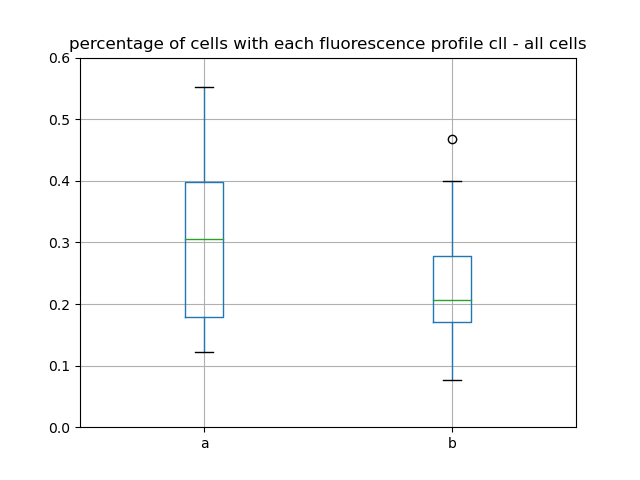

In [96]:
fluotype_count = pd.DataFrame(columns = ftypes)
agg_df = pd.DataFrame()
for mouse, region, code in all_rois:
    if code in ['c'] and mouse != '9' and mouse != '19':
        print(mouse, region)
        res = np.array([])
        df = pd.read_csv(dir_path + cell_data_fn_template.format(mouse, region, "merged"))
        bgrs_ = get_bgrs(df)
        df["fluo_type"] = df.apply(lambda row : find_fluorescence_profile(row, bgrs_), axis = 1)

        df.i0 = df.i0 - bgrs_[0]
        df.i1 = df.i1 - bgrs_[1]
        df.i2 = df.i2 - bgrs_[2]
        df = df[((df.i0 > 0) | (df.i1> 0) | (df.i2> 0))]


        df['sd1'] = abs(df.i2 - df.i0)
        df['sd2'] = abs(df.i1 - df.i0)
        df['ss'] = abs(df.i2 - df.i1)

        grouped = df.groupby('fluo_type').agg({'i0':'mean', 'i1':'mean','i2':'mean',
                                               'sd1': 'mean', 'sd2': 'mean', 'ss': 'mean',
                                               'fluo_type' :'count'})
        for ftype in ftypes:
            if not grouped[grouped.index==ftype].empty:
                res= np.append(res, int(grouped[grouped.index==ftype].fluo_type)/df.shape[0])
            else:
                res= np.append(res,0)
                #print(ftype)
        if code =='c':
            res=np.append(res, 'green')
        else:
            res=np.append(res, 'blue')
            
        fluotype_count = fluotype_count.append(pd.DataFrame(res.reshape(1,-1), 
                                                            columns=np.append(ftypes, 'color')))
        agg_df = agg_df.append(df)
grouped_agg = agg_df.groupby('fluo_type').agg({'i0':'mean', 'i1':'mean','i2':'mean',
                                               'sd1': 'mean', 'sd2': 'mean', 'ss': 'mean',
                                               'fluo_type' :'count'})
for ftype in ftypes:
    fluotype_count[ftype] = fluotype_count[ftype].astype(float)

fluotype_count.boxplot(column=['a', 'b'])
plt.title("percentage of cells with each fluorescence profile cll - all cells")
plt.ylim(0, 0.6)
plt.show()

In [821]:
np.array(fluotype_count['a'])

array([0.35433884, 0.41047246, 0.45806269, 0.36901318, 0.48617456,
       0.45942749, 0.34367763, 0.27066975, 0.32447466, 0.28861789,
       0.25429799, 0.25739645, 0.29472193, 0.41751394, 0.44348993,
       0.33811056, 0.37213343, 0.44099379, 0.36589246, 0.42374402,
       0.31092855, 0.34807097, 0.44588383, 0.41493352, 0.42698528,
       0.38214065, 0.35536076, 0.29363337, 0.35226302, 0.35619887,
       0.28630137, 0.35345745, 0.29868349, 0.42900919, 0.35924007,
       0.35187424, 0.31231321, 0.25844669, 0.21339114, 0.38040748,
       0.30327193, 0.4352518 , 0.41470844, 0.25866917, 0.25393185,
       0.26717801])

<IPython.core.display.Javascript object>


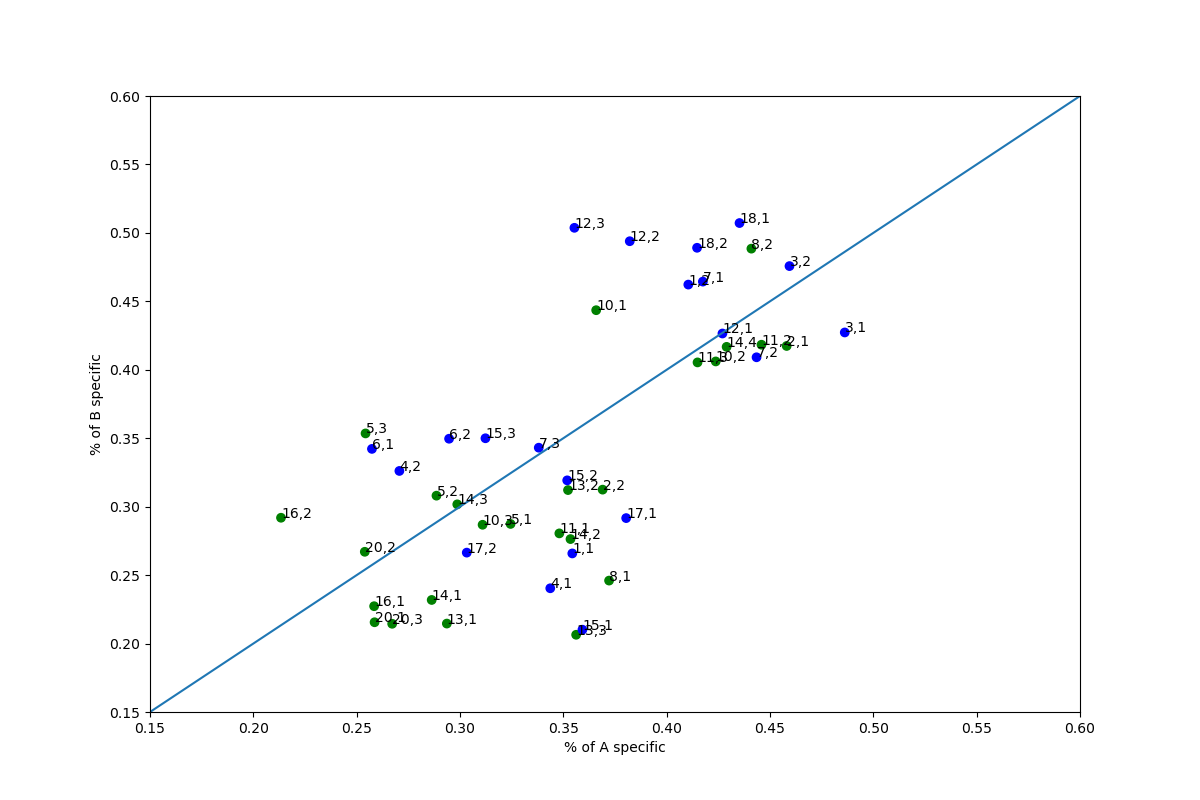

In [829]:
a = np.array(fluotype_count['a'])
b = np.array(fluotype_count['b'])
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(x=a,y=b, c=fluotype_count['color'])
plt.xlim(0.15,0.6)
plt.ylim(0.15,0.6)
plt.xlabel("% of A specific")
plt.ylabel("% of B specific")
plt.plot([0.15,0.6], [0.15,0.6])

i = 0
for m,r, c in all_rois:
    if m != '9' and m != '19':
        ax.annotate(m+','+r, (a[i], b[i]))
        i+=1
plt.show()

In [783]:
def merge_overlap_with_all_session_cells(session_idx, overlapping_session_idx, df, overlap_df, 
                                         left_full):
    if left_full:
        idx_order = [1, 0]
    else:
        idx_order = [0, 1]

    ret = df.merge(overlap_df, how='outer', left_index = True, 
                                      right_on = 'idx'+str(idx_order[1]+1))
    ret = ret[['intensity_standarized', 'idx1', 'idx2', 'intensity'+str(idx_order[0]+1)]]
    ret[['intensity'+str(idx_order[0]+1)]] = ret[['intensity'+str(idx_order[0]+1)]].fillna(value=0)
    ret = ret.rename(columns={'intensity_standarized':'i'+str(session_idx), 
                              'intensity'+str(idx_order[0]+1):'i'+str(overlapping_session_idx),
                  'idx'+str(idx_order[0]+1):'idx_s'+str(overlapping_session_idx), 
                              'idx'+str(idx_order[1]+1):'idx_s'+str(session_idx)})
    
    
    
    return ret

In [784]:
def get_all_cells(mouse, region, session_code):
    df_array={}
    
    session_order = sessions[session_code]
    for i in range(len(session_order)):
        df_array[i] = pd.read_csv(dir_path + cell_data_fn_template
                                  .format(mouse, region, session_order[i]), "\t", header=1)
        img =  io.imread(dir_path + img_fn_template
                                  .format(mouse, region, session_order[i])).astype("uint8")
        df_array[i] = df_array[i][df_array[i]['Interior (px)']>30]
        df_array[i] = update_intensity_for_df(df_array[i], img)
    rdf1 = (pd.read_csv(dir_path + cell_data_fn_template
                .format(mouse, region, 
                        session_order[1]+"_"+session_order[0]))).drop_duplicates(subset='idx2') 
    rdf2 = (pd.read_csv(dir_path + cell_data_fn_template
                .format(mouse, region, 
                        session_order[1]+"_"+session_order[2]))).drop_duplicates(subset='idx2') 
    rdf3 = (pd.read_csv(dir_path + cell_data_fn_template
                .format(mouse, region, 
                        session_order[0]+"_"+session_order[2]))).drop_duplicates(subset='idx2') 

    ret = merge_overlap_with_all_session_cells(0, 1, df_array[0], rdf1,False)
    
    ret = df_array[1].merge(ret, how='outer', left_index = True, right_on = 'idx_s1')
    ret[['i0']] = ret[['i0']].fillna(0)
    ret['i1'] = np.where(ret['i1'].isnull(), ret['intensity_standarized'], 
                                ret['i1'])
    ret = ret[['idx_s0', 'idx_s1', 'i0', 'i1']]
    
    retBB = merge_overlap_with_all_session_cells(1, 2, df_array[1], rdf2,True)
    retBA = merge_overlap_with_all_session_cells(2, 0, df_array[2], rdf3,False)
    
    retBB = retBB.drop(columns='i1')
    ret = ret.merge(retBB, how='outer', on='idx_s1')
    retBA = retBA.drop(columns='i0')
    ret.idx_s0 = ret.idx_s0.fillna(-1)
    ret = ret.merge(retBA, how='left', on='idx_s0')
    
    ret['i2'] = np.where(ret['i2_x'].isnull(), ret['i2_y'], 
                                   ret['i2_x'])
    ret['idx_s2'] = np.where(ret['idx_s2_x'].isnull(), ret['idx_s2_y'], 
                                   ret['idx_s2_x'])
    ret = ret.drop(columns=['i2_x', 'i2_y', 'idx_s2_x', 'idx_s2_y'])
    
    df_a = pd.DataFrame()
    df_a['idx_s2'] = df_array[2].index
    df_a['i2'] = df_array[2].intensity_standarized
    df_a == df_a[['idx_s2', 'i2']]
    
    ret = ret.merge(df_a, how='outer', on='idx_s2')
    ret['i2'] = np.where(ret['i2_x'].isnull(), ret['i2_y'],
                                   ret['i2_x'])
    ret = ret.drop(columns=['i2_x', 'i2_y'])
    ret[['i0','i1','i2']] = ret[['i0',
                                                               'i1','i2']].fillna(0)
    
    ret.to_csv(dir_path + cell_data_fn_template.format(mouse, region, "merged"))
    return ret

In [785]:
for m,r,c in all_rois:
    get_all_cells(m, r,c)

In [344]:
for m in np.unique(all_rois[:,0]):
    
    mouse_rois = all_rois[all_rois[:,0]==m]
    session_code =  mouse_rois[0][-1]
    summary_df = {}
    session_order = sessions[session_code]
    for i in range(3):
        summary_df[i]=pd.DataFrame()

    intensity_difs = np.array([])
    for mouse, region,c in mouse_rois:
        df_array={}
        img_array={}

        pathname = dir_path + cell_data_fn_template.format(mouse, region, session_order[i])
        print(pathname)
        if path.exists(pathname):
            for i in range(len(session_order)):
                df_array[i] = pd.read_csv(dir_path + cell_data_fn_template
                                          .format(mouse, region, session_order[i]), "\t", header=1)
                img_array[i] =  io.imread(dir_path + img_fn_template
                                          .format(mouse, region, session_order[i])).astype("uint8")
            for i in range(len(session_order)):
                df_array[i] = df_array[i][df_array[i]['Interior (px)']>30]
                df_array[i] = update_intensity_for_df(df_array[i], img_array[i])
            bgrs = find_background_intensities(df_array)
            for i in range(len(session_order)):
                df = df_array[i] - bgrs[i]
                df_array[i] = df[df.intensity_standarized>df.intensity_standarized.quantile(0.75)]
                summary_df[i] = summary_df[i].append(df_array[i])
        intensity_difs = np.append(intensity_difs, np.mean(summary_df[0].intensity_standarized)
                                   -np.mean(summary_df[1].intensity_standarized))
    behav_df.loc[int(m), 'avg_int'] = np.mean(intensity_difs)
    print(mouse, region, np.mean(intensity_difs))
        

/media/ula/DATADRIVE1/fos_gfp_tmaze/ctx_landmark/despeckle/alignment_result/aligned_despeckle/m1r1_ctx2_output.txt
/media/ula/DATADRIVE1/fos_gfp_tmaze/ctx_landmark/despeckle/alignment_result/aligned_despeckle/m1r2_ctx2_output.txt
1 2 9.392332794719316
/media/ula/DATADRIVE1/fos_gfp_tmaze/ctx_landmark/despeckle/alignment_result/aligned_despeckle/m10r1_landmark2_output.txt
/media/ula/DATADRIVE1/fos_gfp_tmaze/ctx_landmark/despeckle/alignment_result/aligned_despeckle/m10r2_landmark2_output.txt
/media/ula/DATADRIVE1/fos_gfp_tmaze/ctx_landmark/despeckle/alignment_result/aligned_despeckle/m10r3_landmark2_output.txt
10 3 0.19974276049020526
/media/ula/DATADRIVE1/fos_gfp_tmaze/ctx_landmark/despeckle/alignment_result/aligned_despeckle/m11r1_landmark2_output.txt
/media/ula/DATADRIVE1/fos_gfp_tmaze/ctx_landmark/despeckle/alignment_result/aligned_despeckle/m11r2_landmark2_output.txt
/media/ula/DATADRIVE1/fos_gfp_tmaze/ctx_landmark/despeckle/alignment_result/aligned_despeckle/m11r3_landmark2_output.t

In [345]:
for i in behav_df.index:
    print(behav_df.loc[i].first_cue_exposure, behav_df.loc[i].first_cue_exposure=='landmark')
    if behav_df.loc[i].first_cue_exposure == 'landmark':
        behav_df.loc[i,'color'] = 'blue'
    else:
        behav_df.loc[i,'color'] = 'green'

landmark True
ctx False
landmark True
ctx False
ctx False
landmark True
ctx False
landmark True
landmark True
landmark True
landmark True
ctx False
ctx False
ctx False
ctx False
landmark True
landmark True
landmark True
ctx False
ctx False


In [360]:
behav_df['c_dif'] = behav_df.ctx_avg - behav_df.last_training

<IPython.core.display.Javascript object>


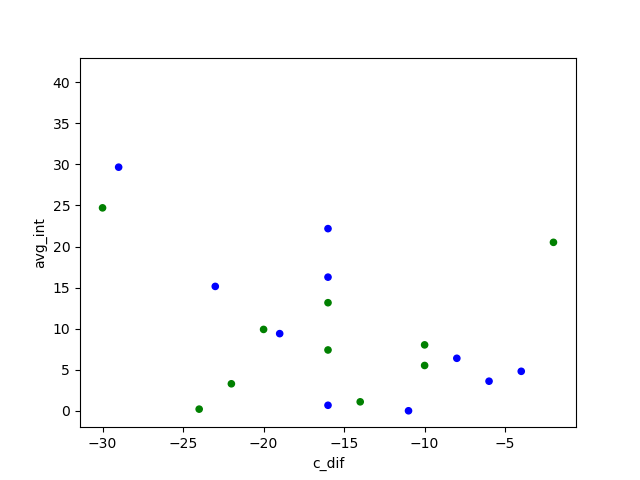

In [361]:
behav_df.plot.scatter('c_dif', 'avg_int', c='color')
plt.ylim(-2,43)
plt.show()

In [904]:
behav_df

,first_cue_exposure,landmark_1st_entry,landmark_avg,ctx_1st_entry,ctx_avg,last_training,first_training,performance diff,retrieval_landmark,retrieval_ctx,avg_int,color,l_dif,c_dif
mouse,,,,,,,,,,,,,,
9,landmark,82,82,46,53,76,68,29,58,60,15.142390,blue,6,-23
11,ctx,96,98,74,74,88,56,24,78,56,1.089523,green,10,-14
6,landmark,90,90,66,67,96,54,23,72,50,29.659007,blue,-6,-29
19,ctx,82,86,64,64,94,46,22,60,52,24.706221,green,-8,-30
13,ctx,90,91,70,70,92,50,21,66,58,3.286508,green,-1,-22
1,landmark,86,86,70,69,88,54,17,54,70,9.392333,blue,-2,-19
20,ctx,94,90,74,74,84,46,16,74,54,5.515148,green,6,-10
7,landmark,84,84,68,69,80,54,15,52,50,0.000000,blue,4,-11
3,landmark,80,80,64,66,82,54,14,64,48,22.175725,blue,-2,-16


In [97]:
cols = ['m', 'r', 'avg_i0', 'avg_i1', 'avg_i2', 'ov_ab_a', 'ov_ab_b', 'ov_bb_b1', 'ov_bb_b2', 
        'a_solo', 'b_solo']
summary_df_l = pd.DataFrame(columns = cols)
summary_df_c = pd.DataFrame(columns = cols)

for m, r, code in all_rois:
    merged = pd.read_csv(dir_path + cell_data_fn_template.format(m,r, "merged"))
    bgrs = get_bgrs(merged)
    for i in range(3):
        merged['i'+str(i)] -= bgrs[i]
            
    df1 = merged[merged.i0>0]
    df2 = merged[merged.i1>0]
    df3 = merged[merged.i2>0]
    avg0=np.mean(df1.i0)
    avg1=np.mean(df2.i1)
    avg2=np.mean(df3.i2)
    q=0.9
    avg_i0 = np.mean(df1[df1.i0>df1.i0.quantile(q)].i0)
    avg_i1 = np.mean(df2[df2.i1>df2.i1.quantile(q)].i1)
    avg_i2 = np.mean(df3[df3.i2>df3.i2.quantile(q)].i2)

    ov_ab_a = np.mean(merged[((merged.i0 > 0) & (merged.i1> 0)& (merged.i2<=0))].i0)
    ov_ab_b = np.mean(merged[((merged.i0 > 0) & (merged.i1> 0))].i1)
    ov_bb_b1 = np.mean(merged[((merged.i1 > 0) & (merged.i2> 0))].i1)
    ov_bb_b2 = np.mean(merged[((merged.i1 > 0) & (merged.i2> 0)& (merged.i1<=0))].i2)
    
    asolo = np.mean(merged[((merged.i0 > 0) & (merged.i1<= 0)& (merged.i2<= 0))].i0)/avg0
    bsolo = np.mean(merged[((merged.i0 <= 0) & (merged.i1> 0)& (merged.i2<= 0))].i1)/avg1

    avgs = pd.DataFrame([[m, r, avg_i0, avg_i1, avg_i2, ov_ab_a, ov_ab_b, ov_bb_b1, ov_bb_b2, 
                          asolo, bsolo]],
                        columns = cols)
    if code == 'l':
        summary_df_l = pd.concat([summary_df_l, avgs])
    if code == 'c':
        summary_df_c = pd.concat([summary_df_c, avgs])


<IPython.core.display.Javascript object>


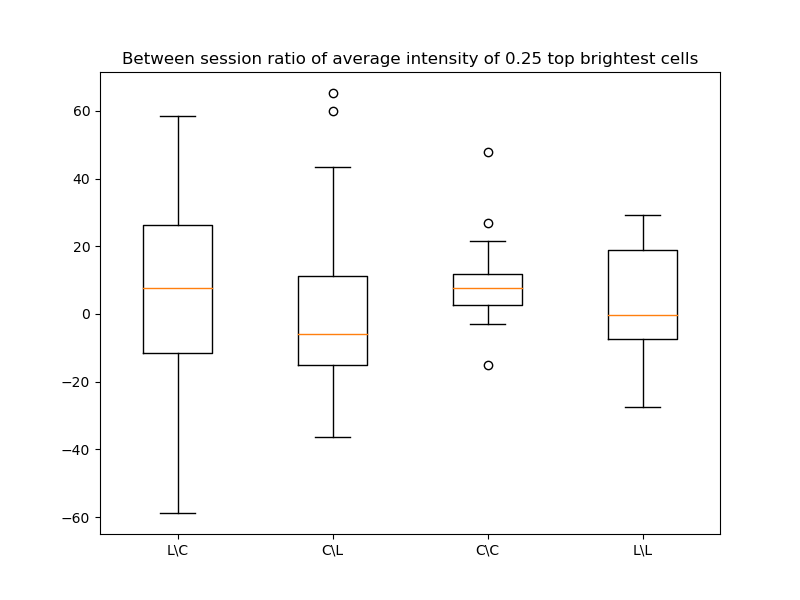

In [98]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.boxplot([summary_df_l.avg_i0-summary_df_l.avg_i1, summary_df_c.avg_i0-summary_df_c.avg_i1, 
             summary_df_l.avg_i1-summary_df_l.avg_i2, summary_df_c.avg_i1-summary_df_c.avg_i2])
plt.title('Between session ratio of average intensity of 0.25 top brightest cells')
ax.set_xticklabels(['L\C', 'C\L', 'C\C', 'L\L'])
#ax.set_ylim(0.25,2.1)
plt.show()

<IPython.core.display.Javascript object>


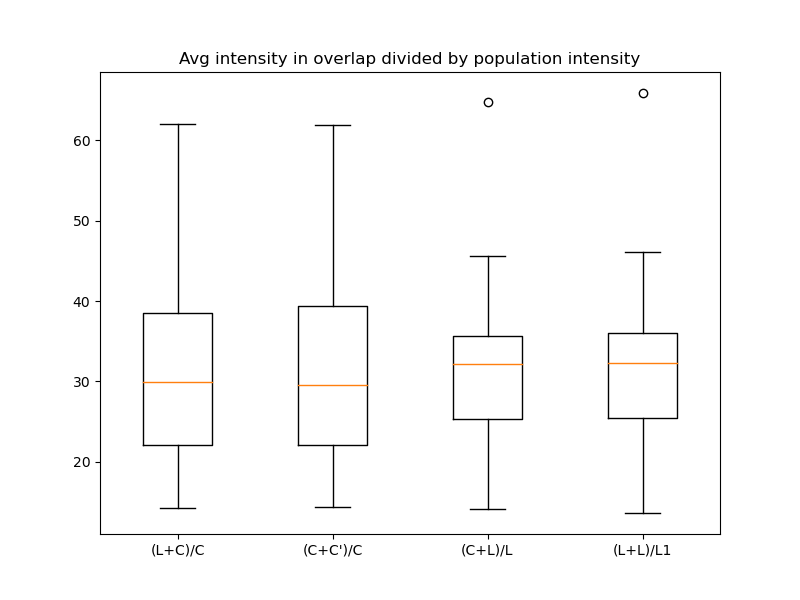

In [1018]:
fig, ax = plt.subplots(figsize=(8, 6))

plt.boxplot([summary_df_l.ov_ab_b, summary_df_l.ov_bb_b1, 
             summary_df_c.ov_ab_b, summary_df_c.ov_bb_b1])
plt.title('Avg intensity in overlap divided by population intensity')
ax.set_xticklabels(['(L+C)/C', "(C+C')/C", '(C+L)/L', '(L+L)/L1'])
plt.show()

In [976]:
ret2

array([[1618., 1778., 1652., 1135.,  706.,  827.,  488.],
       [2040., 2284., 2180., 1492., 1502., 1274., 1089.],
       [2443., 2471., 2427., 1327., 1416., 1628., 1019.],
       [2263., 2256., 2212.,  944., 1283., 1144.,  692.],
       [2331., 2448., 2362., 1713., 1453., 1562., 1147.],
       [2445., 2674., 2579., 1894., 1901., 1841., 1539.],
       [2604., 2569., 2686., 1696., 1659., 1644., 1266.],
       [2660., 2865., 3013., 1714., 1558., 1568., 1089.],
       [1657., 1697., 1736.,  958.,  949.,  896.,  662.],
       [1087., 1040., 1151.,  687.,  713.,  685.,  529.],
       [1693., 1691., 1790., 1243., 1180., 1279.,  982.],
       [2103., 2114., 2188., 1302., 1341., 1560., 1049.],
       [ 842.,  970.,  964.,  455.,  493.,  528.,  300.],
       [1249., 1336., 1232.,  656.,  682.,  619.,  382.],
       [1448., 1396., 1428.,  937.,  976., 1001.,  764.],
       [1398., 1466., 1538., 1010., 1037., 1048.,  823.],
       [ 600.,  638.,  638.,  338.,  480.,  430.,  287.],
       [1360.,

<IPython.core.display.Javascript object>


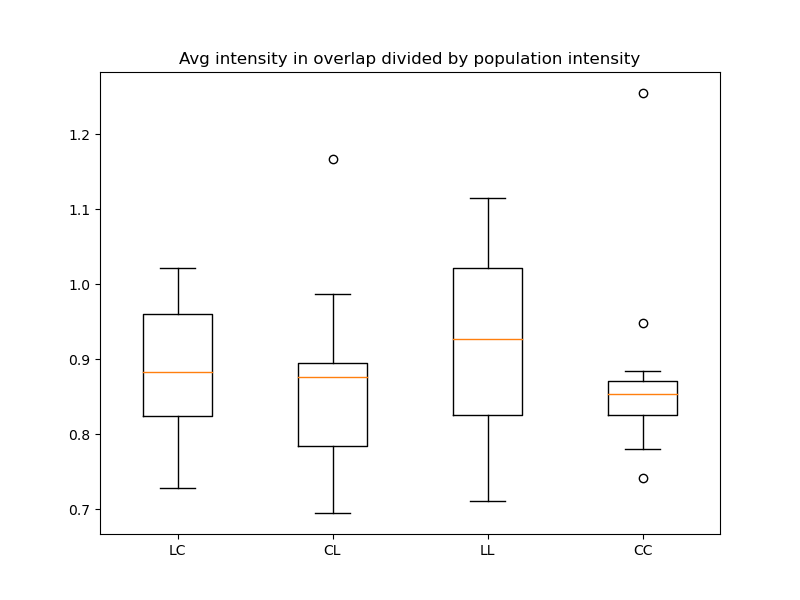

In [1008]:
fig, ax = plt.subplots(figsize=(8, 6))

plt.boxplot([summary_df_l.ov_ab_b, summary_df_c.ov_ab_b,  
             summary_df_l.ov_bb_b1, summary_df_c.ov_bb_b1])
plt.title('Avg intensity in overlap divided by population intensity')
ax.set_xticklabels(['LC', 'CL', 'LL', 'CC'])
plt.show()

In [76]:
df_m = pd.read_csv(dir_path + cell_data_fn_template.format(1, 2, "merged"))
df_o = pd.read_csv(dir_path + cell_data_fn_template.format(1, 2, "ordered"))

Code for percentile based thresholding

In [554]:
cols = ['i0', 'i1', 'i2']
summary_df_l1 = pd.DataFrame(columns = cols)
summary_df_l2 = pd.DataFrame(columns = cols)
summary_df_l3 = pd.DataFrame(columns = cols)
summary_df_c1 = pd.DataFrame(columns = cols)
summary_df_c2 = pd.DataFrame(columns = cols)
summary_df_c3 = pd.DataFrame(columns = cols)

for m, r, code in all_rois:
    ord_cells = pd.read_csv(dir_path + cell_data_fn_template.format(m,r, "merged"))
    q=0.95
    s1_f0 = ord_cells[ord_cells.i0>0].i0.quantile(q)
    s2_f0 = ord_cells[ord_cells.i1>0].i1.quantile(q)
    s3_f0 = ord_cells[ord_cells.i2>0].i2.quantile(q)
    
    ord_cells.i0 /= s1_f0
    ord_cells.i1 /= s2_f0
    ord_cells.i2 /= s3_f0
    
    df1 = ord_cells[(ord_cells.i0>1)]
    df2 = ord_cells[(ord_cells.i1>1)]
    df3 = ord_cells[(ord_cells.i2>1)]
    
    if code == 'l':
        summary_df_l1 = pd.concat([summary_df_l1, df1])
        summary_df_l2 = pd.concat([summary_df_l2, df2])
        summary_df_l3 = pd.concat([summary_df_l3, df3])
    if code == 'c':
        summary_df_c1 = pd.concat([summary_df_c1, df1])
        summary_df_c2 = pd.concat([summary_df_c2, df2])
        summary_df_c3 = pd.concat([summary_df_c3, df3])

Code with division by mean (inspired by MM)

In [1231]:
cols = ['i0', 'i1', 'i2','i0s', 'i1s', 'i2s']
summary_df_l1 = pd.DataFrame(columns = cols)
summary_df_l2 = pd.DataFrame(columns = cols)
summary_df_l3 = pd.DataFrame(columns = cols)
summary_df_c1 = pd.DataFrame(columns = cols)
summary_df_c2 = pd.DataFrame(columns = cols)
summary_df_c3 = pd.DataFrame(columns = cols)

weight_sum = np.zeros(6)

for m, r, code in all_rois:
    ord_cells = pd.read_csv(dir_path + cell_data_fn_template.format(m,r, "merged"))
    q=0.25
    
    s1_f0 = ord_cells[ord_cells.i0>0].i0.quantile(q)
    s2_f0 = ord_cells[ord_cells.i1>0].i1.quantile(q)
    s3_f0 = ord_cells[ord_cells.i2>0].i2.quantile(q)
    max_bgr = max([s1_f0,s2_f0,s3_f0])

    ord_cells = ord_cells[((ord_cells.i0>s1_f0) | (ord_cells.i1>s2_f0)| (ord_cells.i2>s3_f0))]
    
    ord_cells = ord_cells[['i0', 'i1', 'i2']]
    
    ord_cells = ord_cells.loc[((abs(ord_cells.max(axis=1) - ord_cells.min(axis=1))>max_bgr)|
                               (ord_cells.i0<s1_f0)|(ord_cells.i1<s2_f0)|
               (ord_cells.i2<s3_f0))]
    
    '''
    df1.i1 = df1.i1/s2_f0
    df1.i2 = df1.i2/s3_f0
    df1.i0 = df1.i0/s1_f0
    '''
    df1 = ord_cells[(ord_cells.i0>s1_f0) & (ord_cells.i1>s2_f0) & (ord_cells.i2>s3_f0)]
    df2 = ord_cells[(ord_cells.i1>s2_f0) & (ord_cells.i2>s3_f0) & (ord_cells.i0>s1_f0)]
    df3 = ord_cells[(ord_cells.i0>s1_f0) & (ord_cells.i2>s3_f0)]
    
    #df1 *= df1.shape[0]
    #df2 *= df2.shape[0]
    #df3 *= df3.shape[0]
    
    if code == 'l':
        summary_df_l1 = pd.concat([summary_df_l1, df1])
        summary_df_l2 = pd.concat([summary_df_l2, df2])
        summary_df_l3 = pd.concat([summary_df_l3, df3])
        weight_sum[0]+= df1.shape[0]**2
        weight_sum[1]+= df2.shape[0]**2
        weight_sum[2]+= df3.shape[0]**2
    if code == 'c':
        summary_df_c1 = pd.concat([summary_df_c1, df1])
        summary_df_c2 = pd.concat([summary_df_c2, df2])
        summary_df_c3 = pd.concat([summary_df_c3, df3])
        weight_sum[3]+= df1.shape[0]**2
        weight_sum[4]+= df2.shape[0]**2
        weight_sum[5]+= df3.shape[0]**2

<IPython.core.display.Javascript object>


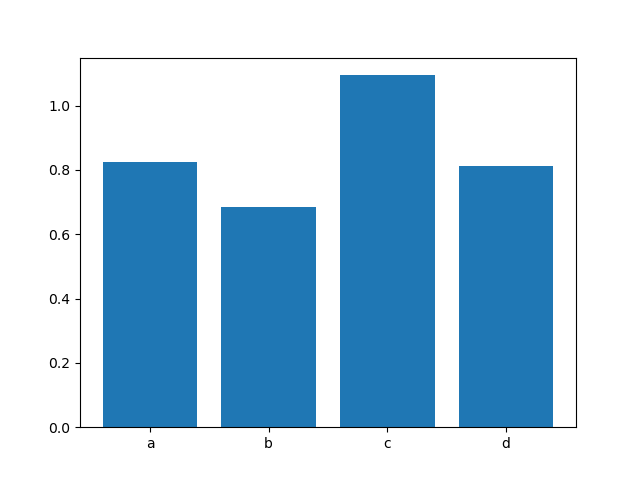

In [1225]:
plt.bar(['a', 'b', 'c', 'd'], [np.mean(summary_df_l1.i1)/np.mean(summary_df_l1.i0),
        np.mean(summary_df_l3.i2)/np.mean(summary_df_l3.i0),
        np.mean(summary_df_c1.i1)/np.mean(summary_df_c1.i0),
        np.mean(summary_df_c2.i2)/np.mean(summary_df_c2.i1)])
plt.show()
print()

<IPython.core.display.Javascript object>


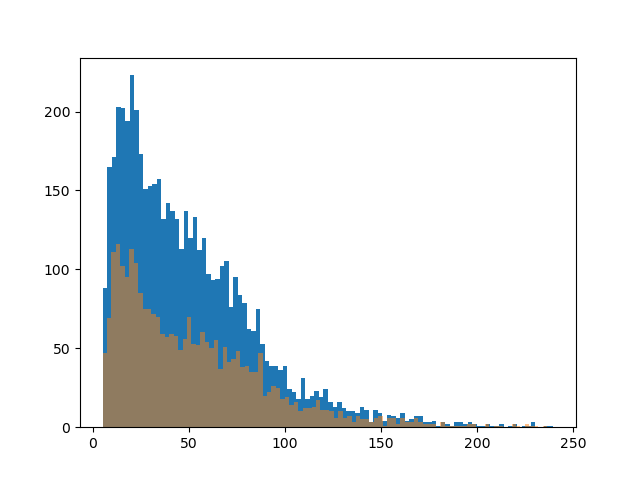

In [1245]:
tst_df = summary_df_c1[(abs(summary_df_c1.i1-summary_df_c1.i2)/summary_df_c1.i1)<0.5]
tst_df2 = summary_df_c1[(abs(summary_df_c1.i1-summary_df_c1.i2)/summary_df_c1.i1)<0.3]

plt.hist(tst_df.i0,bins=100)
plt.hist(tst_df2.i0,bins=100, alpha=0.5)
plt.show()

In [1218]:
def plot_scaled_diff_hist(df, cols, bns, rnge, alpha=1):
    plt.hist(((df[cols[0]]-df[cols[1]]))/df[cols[0]], bins=bns, range=rnge, alpha=alpha)
    plt.ylim(0, 1000)
    
def plot_scaled_diff(dfs, cols, ticks):
    
    data = np.array([])
    for i, df in enumerate(dfs):
        print(cols[2*i],cols[2*i+1])
        data = np.append(data, np.mean(abs(df[cols[2*i]]-df[cols[2*i+1]])/df[cols[2*i]]))
        print(np.mean(abs(df[cols[2*i]]-df[cols[2*i+1]])/df[cols[2*i]]))
    
    plt.bar(ticks, data)
    plt.ylim(0)
    plt.show()

i0 i1
0.5683346832054148
i1 i2
0.3953592906885299
i0 i2
0.473929930642569


<IPython.core.display.Javascript object>


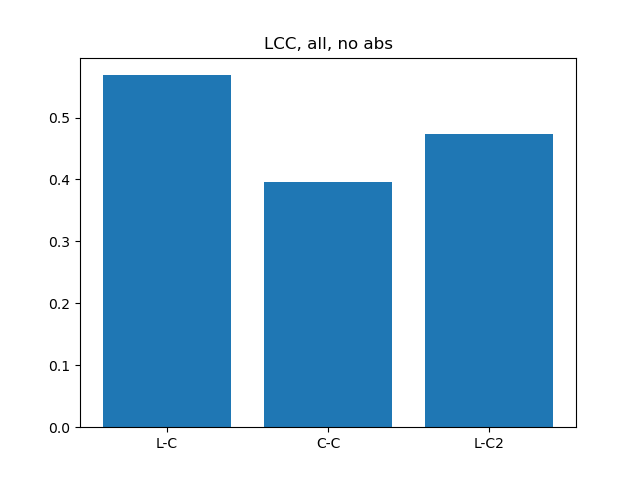

i0 i1
0.7407011170480018
i1 i2
0.4348769316770749
i0 i2
0.6083757186316731


<IPython.core.display.Javascript object>


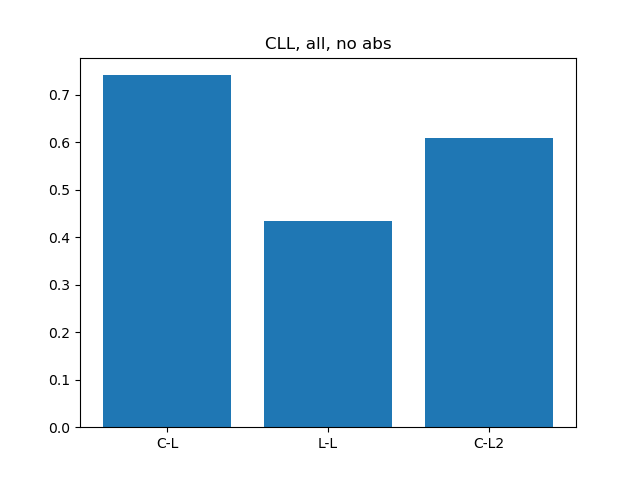

In [1228]:
plt.title("LCC, all, no abs")
plot_scaled_diff([summary_df_l1, summary_df_l2, summary_df_l3], ['i0', 'i1', 'i1', 
                                    'i2','i0', 'i2'], ["L-C","C-C", "L-C2"])
plt.title("CLL, all, no abs")
plot_scaled_diff([summary_df_c1, summary_df_c2, summary_df_c3], ['i0', 'i1', 'i1', 
                                    'i2','i0', 'i2'], ["C-L", "L-L", "C-L2"])

<IPython.core.display.Javascript object>


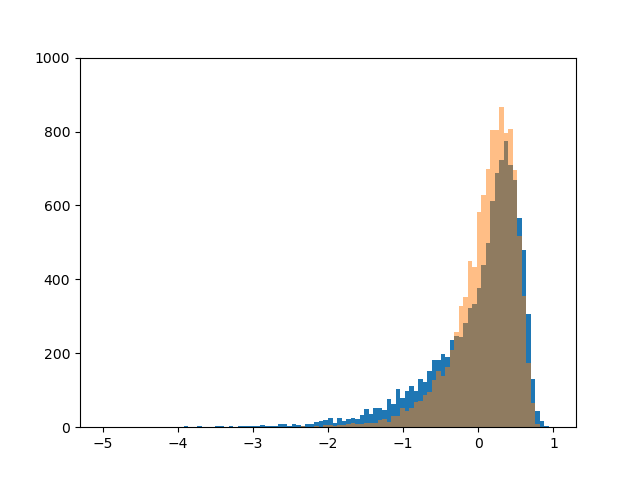

<IPython.core.display.Javascript object>


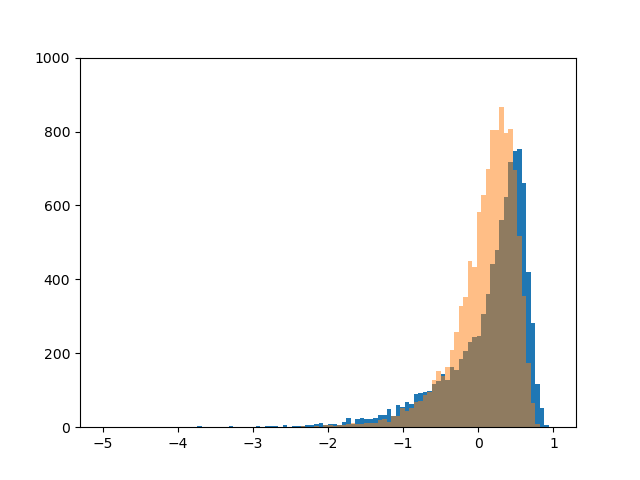

<IPython.core.display.Javascript object>


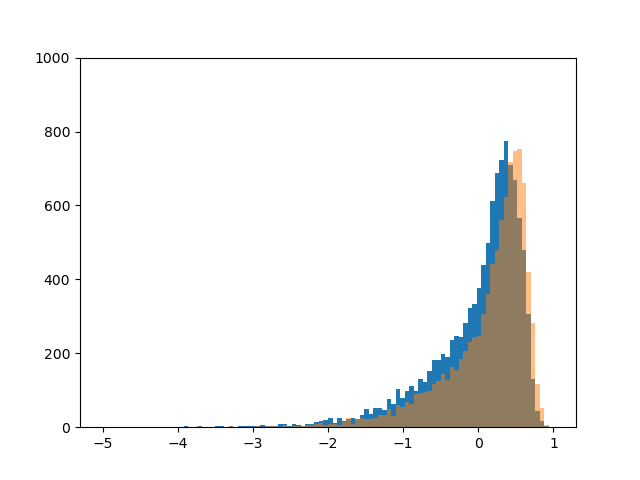

In [1125]:
bns = 100
rnge = (-5,1)
plot_scaled_diff_hist(summary_df_l1, ['i0', 'i1'], bns, rnge)
plot_scaled_diff_hist(summary_df_l2, ['i1', 'i2'], bns, rnge, alpha = 0.5)
plt.show()
plot_scaled_diff_hist(summary_df_l3, ['i0', 'i2'], bns, rnge)
plot_scaled_diff_hist(summary_df_l2, ['i1', 'i2'], bns, rnge, alpha = 0.5)
plt.show()
plot_scaled_diff_hist(summary_df_l1, ['i0', 'i1'], bns, rnge)
plot_scaled_diff_hist(summary_df_l3, ['i0', 'i2'], bns, rnge, alpha = 0.5)
plt.show()

<IPython.core.display.Javascript object>


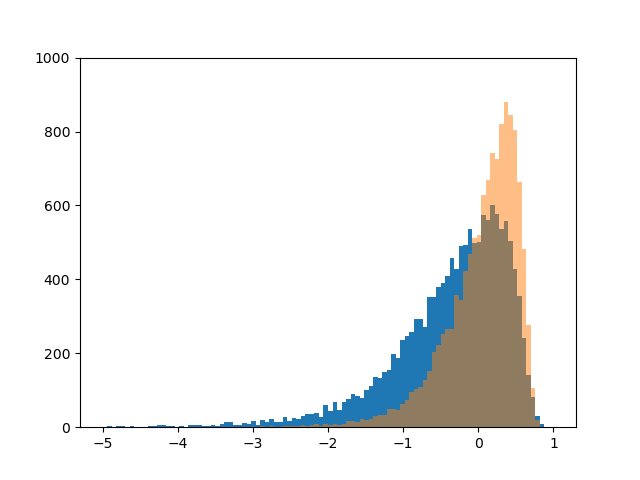

<IPython.core.display.Javascript object>


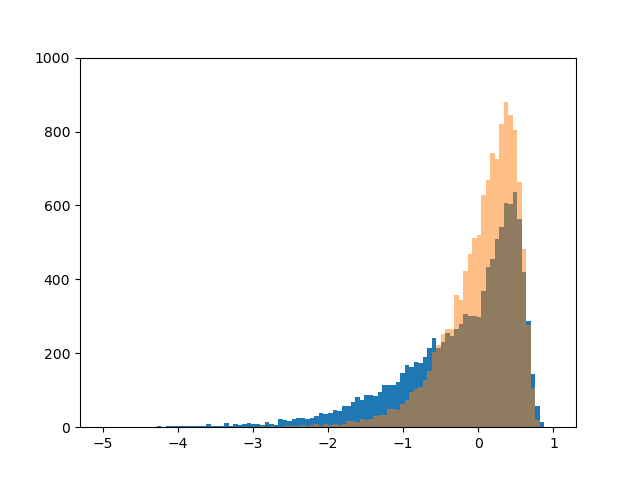

<IPython.core.display.Javascript object>


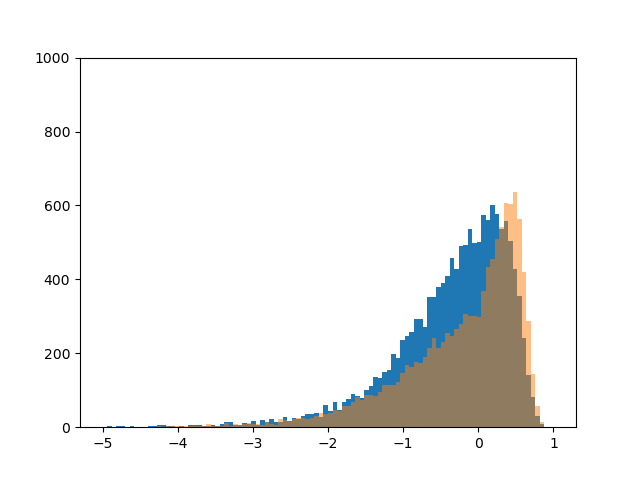

In [1120]:
plot_scaled_diff_hist(summary_df_c1, ['i0', 'i1'], bns, rnge)
plot_scaled_diff_hist(summary_df_c2, ['i1', 'i2'], bns, rnge, alpha = 0.5)
plt.show()
plot_scaled_diff_hist(summary_df_c3, ['i0', 'i2'], bns, rnge)
plot_scaled_diff_hist(summary_df_c2, ['i1', 'i2'], bns, rnge, alpha = 0.5)
plt.show()
plot_scaled_diff_hist(summary_df_c1, ['i0', 'i1'], bns, rnge)
plot_scaled_diff_hist(summary_df_c3, ['i0', 'i2'], bns, rnge, alpha = 0.5)
plt.show()

<IPython.core.display.Javascript object>


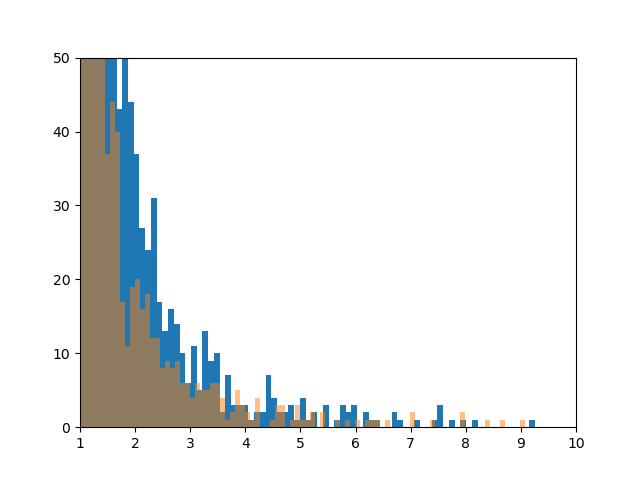

<IPython.core.display.Javascript object>


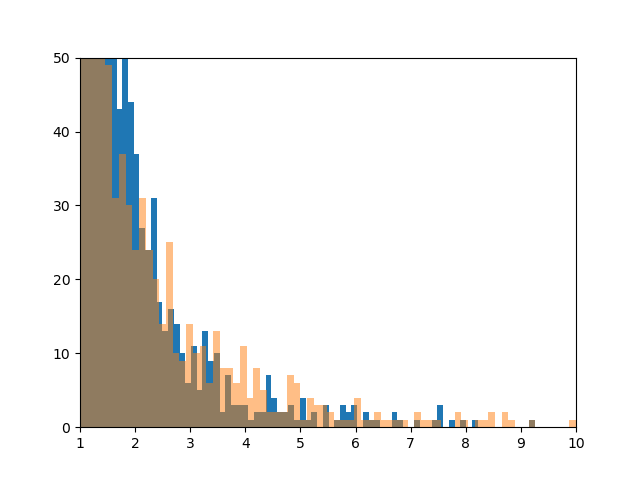

In [926]:
xxx = summary_df_c1[(summary_df_c1.i0>1) & (summary_df_c1.i1>1)]
yyy = summary_df_c1[(summary_df_c1.i1>1) & (summary_df_c1.i2>1)]
zzz = summary_df_c1[(summary_df_c1.i0>1) & (summary_df_c1.i2>1)]
#xxx = xxx[(xxx.i0 - xxx.i1>1)]
#yyy = yyy[(yyy.i1 - yyy.i2>1)]
plt.hist(abs(xxx.i1 - xxx.i0), bins=100)
plt.hist(abs(yyy.i1 - yyy.i2), bins=100, alpha = 0.5)
plt.xlim(1, 10)
plt.ylim(0,50)
plt.show()
plt.hist(abs(xxx.i0 - xxx.i1), bins=100)
plt.hist(abs(zzz.i0 - zzz.i2), bins=100, alpha = 0.5)
plt.xlim(1, 10)
plt.ylim(0,50)
plt.show()

<IPython.core.display.Javascript object>


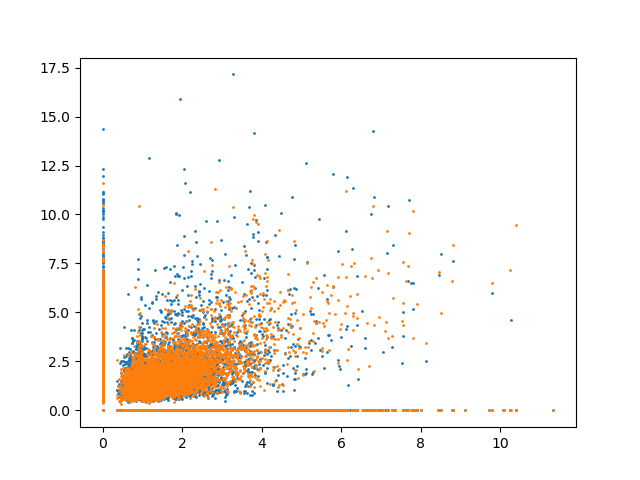

<IPython.core.display.Javascript object>


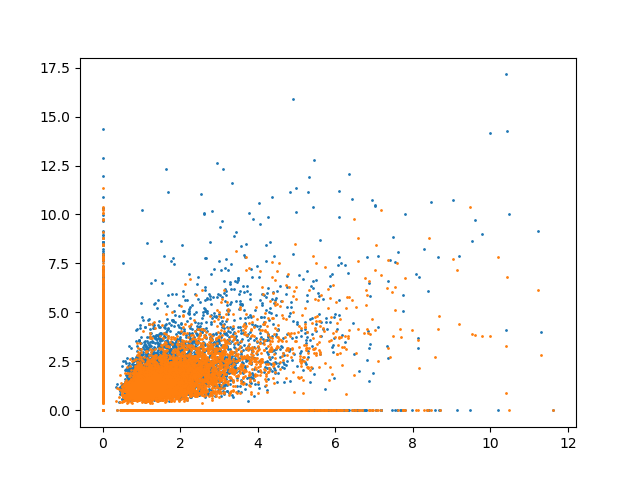

<IPython.core.display.Javascript object>


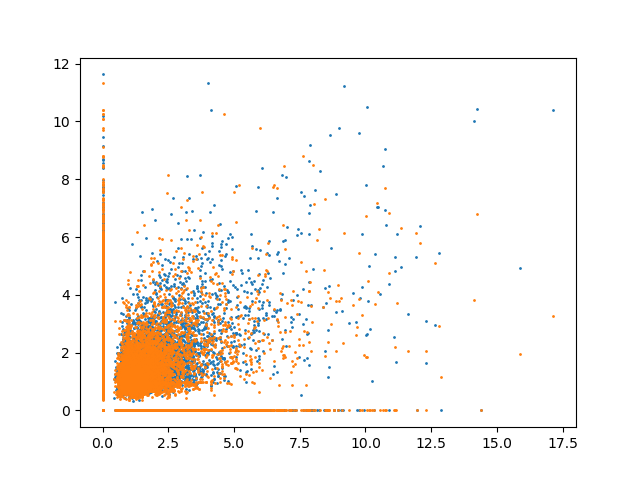

In [899]:
plt.scatter(summary_df_l1.i2, summary_df_l1.i0, s=1)
plt.scatter(summary_df_l1.i2, summary_df_l1.i1, s=1)
plt.show()
plt.scatter(summary_df_l1.i1, summary_df_l1.i0, s=1)
plt.scatter(summary_df_l1.i1, summary_df_l1.i2, s=1)
plt.show()
plt.scatter(summary_df_l1.i0, summary_df_l1.i1, s=1)
plt.scatter(summary_df_l1.i0, summary_df_l1.i2, s=1)
plt.show()

<IPython.core.display.Javascript object>


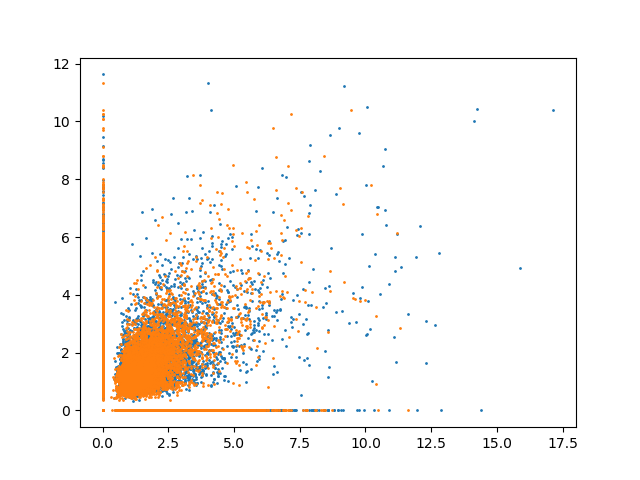

In [872]:



plt.scatter(summary_df_l1.i0 ,summary_df_l1.i1, s=1)
plt.scatter(summary_df_l1.i1 ,summary_df_l1.i2, s=1)
plt.show()


<IPython.core.display.Javascript object>


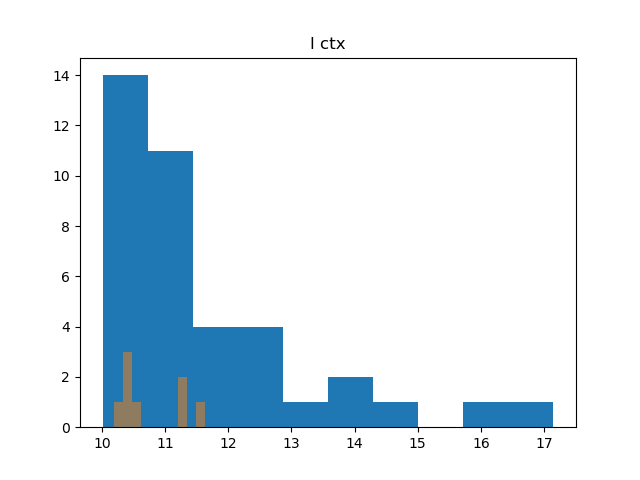

<IPython.core.display.Javascript object>


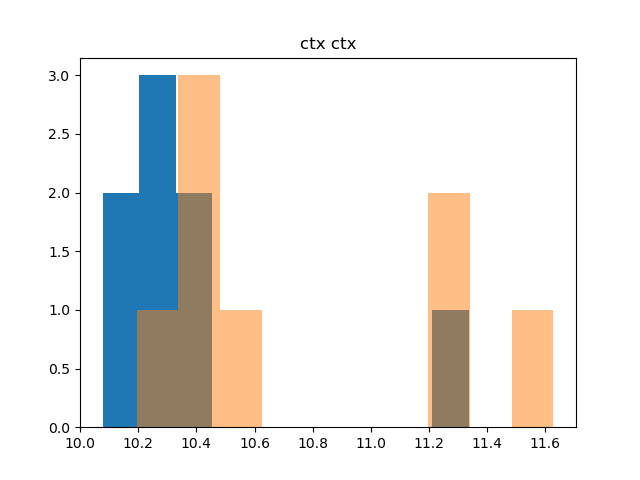

<IPython.core.display.Javascript object>


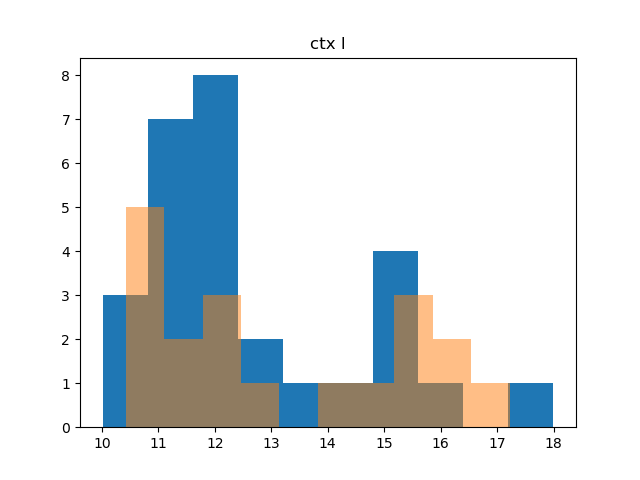

<IPython.core.display.Javascript object>


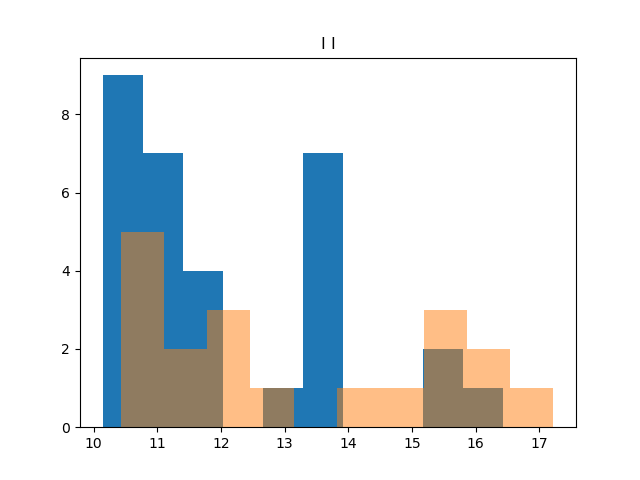

In [897]:
thre=10
plt.hist(summary_df_l1.i0[(summary_df_l1.i0 >thre)], bins=10)
plt.hist(summary_df_l1.i1[summary_df_l1.i1 >thre], bins=10,alpha=0.5)
plt.title("l ctx")
plt.show()
plt.hist(summary_df_l1.i2[summary_df_l1.i2 >thre], bins=10)
plt.hist(summary_df_l1.i1[summary_df_l1.i1 >thre], bins=10, alpha=0.5)
plt.title("ctx ctx")
plt.show()
plt.hist(summary_df_c1.i0[summary_df_c1.i0 >thre], bins=10)
plt.hist(summary_df_c1.i1[summary_df_c1.i1 >thre], bins=10, alpha=0.5)
plt.title("ctx l")
plt.show()
plt.hist(summary_df_c1.i2[summary_df_c1.i2 >thre], bins=10)
plt.hist(summary_df_c1.i1[summary_df_c1.i1 >thre], bins=10, alpha=0.5)
plt.title("l l")
plt.show()

<IPython.core.display.Javascript object>


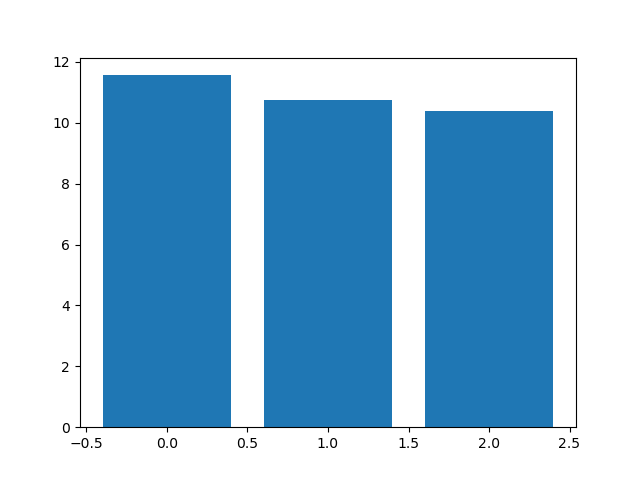

In [898]:

plt.bar(np.arange(3), [np.mean(summary_df_l1[summary_df_l1.i0>thre].i0), 
                       np.mean(summary_df_l1[summary_df_l1.i1>thre].i1),
                      np.mean(summary_df_l1[summary_df_l1.i2>thre].i2)])

'''
plt.bar(np.arange(3), [np.mean(summary_df_c1.i0), np.mean(summary_df_c1.i1),
                      np.mean(summary_df_c1.i2)], alpha=0.5)
'''
plt.show()

In [840]:
summary_df_l1

,i0,i1,i2,i0s,i1s,i2s
0,0.314001,0.297462,0.000000,NaN,NaN,NaN
1,0.000000,0.511071,0.000000,NaN,NaN,NaN
2,0.328840,0.383965,0.000000,NaN,NaN,NaN
3,0.278387,0.375138,0.000000,NaN,NaN,NaN
4,0.000000,0.250765,0.000000,NaN,NaN,NaN
...,...,...,...,...,...,...
2293,0.000000,0.000000,1.222293,NaN,NaN,NaN
2294,0.000000,0.000000,0.525304,NaN,NaN,NaN
2295,0.000000,0.000000,1.005125,NaN,NaN,NaN
2296,0.000000,0.000000,0.588085,NaN,NaN,NaN


<IPython.core.display.Javascript object>


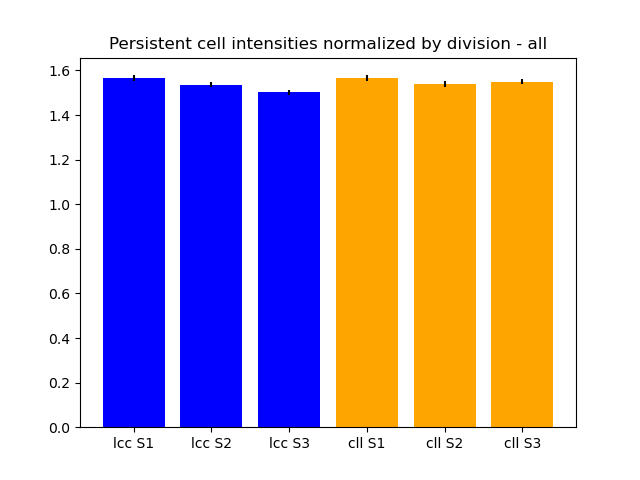

In [477]:
xticks = ['lcc S1', 'lcc S2', 'lcc S3','cll S1', 'cll S2', 'cll S3']

cis = np.empty((2, 6))
confidence = 0.95

for idx, ar in enumerate([summary_df_l1.i0, summary_df_l2.i1,summary_df_l3.i2,
           summary_df_c1.i0, summary_df_c2.i1, summary_df_c3.i2]):
    values = [np.random.choice(ar,size=len(ar),replace=True).mean() for i in range(1000)] 
    cis[:,idx] = np.percentile(values,[100*(1-confidence)/2,100*(1-(1-confidence)/2)])
    cis[0, idx] = np.mean(ar) - cis[0, idx]
    cis[1, idx] -= np.mean(ar)

bar_ticks = np.arange(6)
plt.bar(bar_ticks, [np.mean(summary_df_l1.i0), 
                       np.mean(summary_df_l2.i1),
                       np.mean(summary_df_l3.i2),
                    np.mean(summary_df_c1.i0), 
                       np.mean(summary_df_c2.i1),
                       np.mean(summary_df_c3.i2),], 
        color=['blue', 'blue', 'blue',  'orange', 'orange', 'orange'],
       yerr = cis)
        #[sem(summary_df_l1.i0), np.std(summary_df_l2.i1),sem(summary_df_l3.i2),
         #       sem(summary_df_c1.i0), sem(summary_df_c2.i1),sem(summary_df_c3.i2)])
plt.xticks(bar_ticks, xticks)
plt.title("Persistent cell intensities normalized by division - all")
#plt.ylim(1.75, 2.25)
#plt.plot([1]*summary_df_l2.shape[0],summary_df_l2.i1, marker=".", linestyle="", alpha=0.1, color="r")
plt.show()

<IPython.core.display.Javascript object>


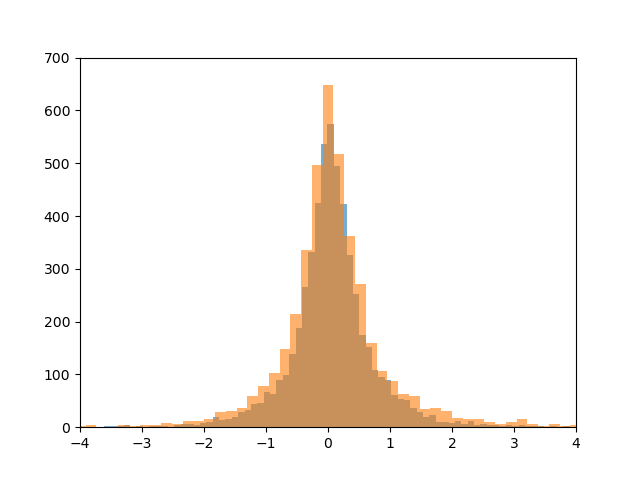

<IPython.core.display.Javascript object>


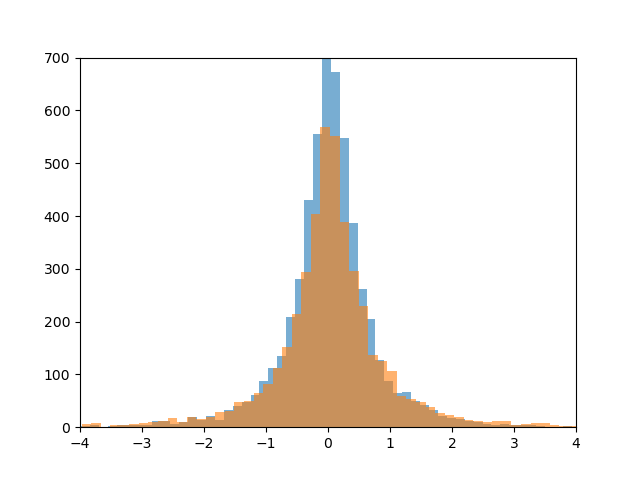

In [431]:
plt.hist(summary_df_l2.i1 -summary_df_l2.i2, bins=100, alpha=0.6)
plt.hist(summary_df_l3.i0 -summary_df_l3.i2, bins=100, alpha=0.6)
plt.xlim(-4,4)
plt.ylim(0, 700)
plt.show()

plt.hist(summary_df_c2.i1 -summary_df_c2.i2, bins=100, alpha=0.6)
plt.hist(summary_df_c3.i0 -summary_df_c3.i2, bins=100, alpha=0.6)
plt.xlim(-4,4)
plt.ylim(0, 700)
plt.show()

In [428]:
summary_df_l1.shape

(6116, 7)

In [1246]:
np.mean(abs(summary_df_c1.i1-summary_df_c1.i0)/summary_df_c1.i0)-np.mean(abs(summary_df_c2.i2-summary_df_c2.i1)/summary_df_c2.i1)

0.3058241853709269

<IPython.core.display.Javascript object>


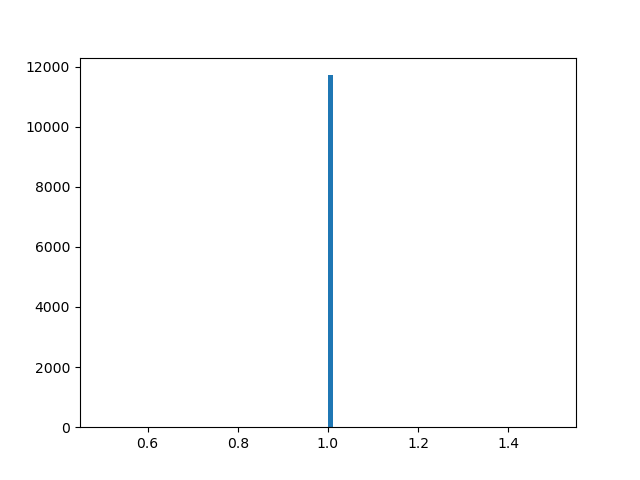

<IPython.core.display.Javascript object>


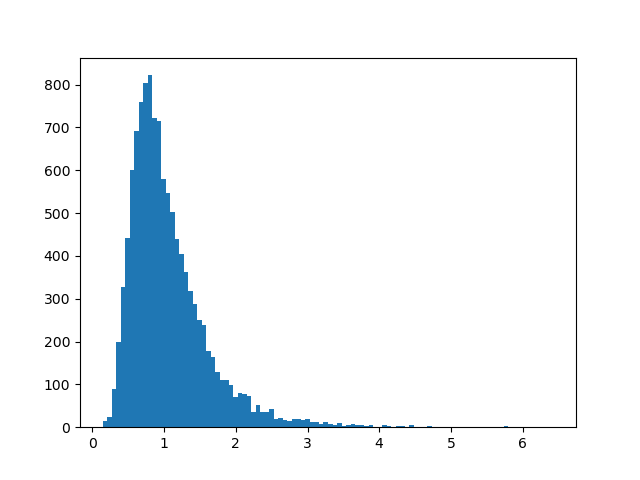

<IPython.core.display.Javascript object>


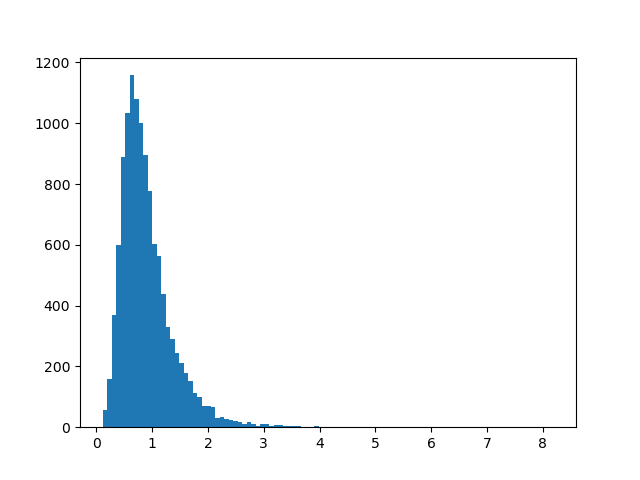

In [294]:
plt.hist(summary_df_l1.i0, bins = 100)
plt.show()
plt.hist(summary_df_l2.i1, bins = 100)
plt.show()
plt.hist(summary_df_l3.i2, bins = 100)
plt.show()

<IPython.core.display.Javascript object>


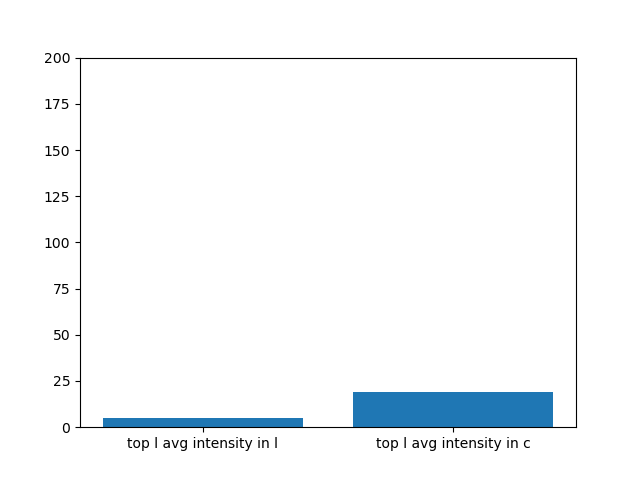

In [80]:
#tmp = s12[s12.intensity_standarized>s12.intensity_standarized.quantile(0.95)]
plt.bar(['top l avg intensity in l', 'top l avg intensity in c'],
    [5, 19])
plt.ylim(0,200)
plt.show()

<IPython.core.display.Javascript object>


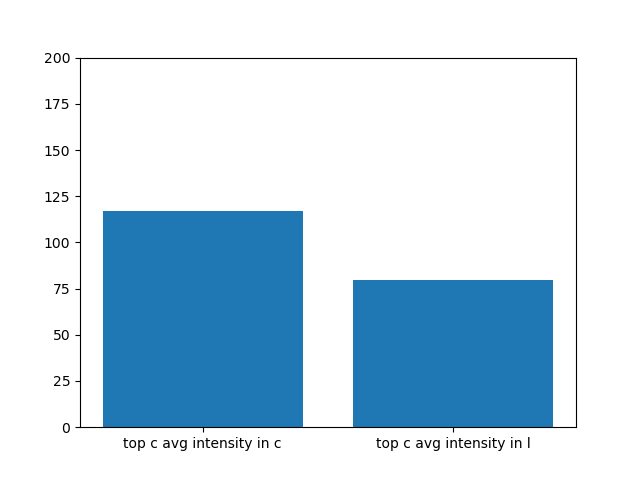

In [129]:
tmp = s21[s21.intensity_standarized>s21.intensity_standarized.quantile(0.95)]
plt.bar(['top c avg intensity in c', 'top c avg intensity in l'],
    [np.mean(tmp.intensity_standarized), np.mean(tmp.intensity2)])
plt.ylim(0,200)
plt.show()

<IPython.core.display.Javascript object>


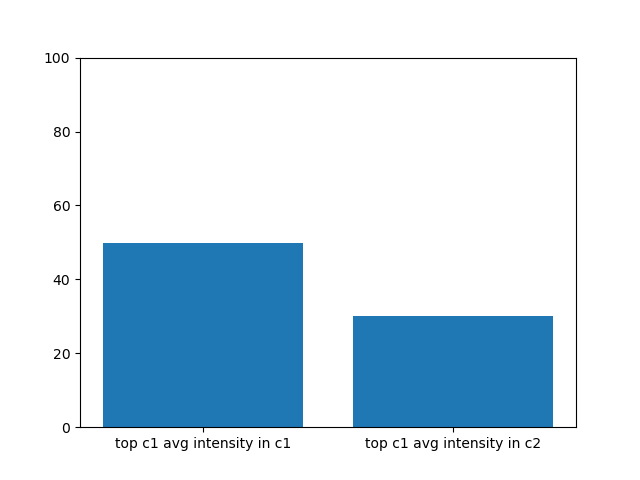

In [621]:
tmp = s23[s23.intensity_standarized>s23.intensity_standarized.quantile(0.95)]
plt.bar(['top c1 avg intensity in c1', 'top c1 avg intensity in c2'],
    [np.mean(tmp.intensity_standarized), np.mean(tmp.intensity2)])
plt.ylim(0,100)
plt.show()

<IPython.core.display.Javascript object>


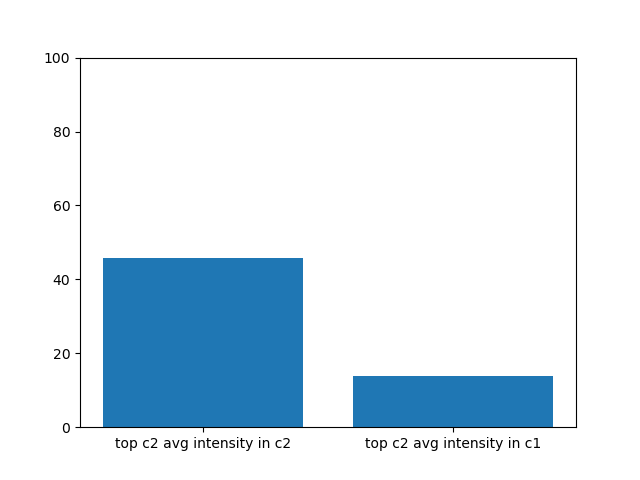

In [622]:
tmp = s32[s32.intensity_standarized>s32.intensity_standarized.quantile(0.95)]
plt.bar(['top c2 avg intensity in c2', 'top c2 avg intensity in c1'],
    [np.mean(tmp.intensity_standarized), np.mean(tmp.intensity1)])
plt.ylim(0,100)
plt.show()

In [623]:
session_order = ctx_session_order

s12 = pd.DataFrame()
s23 = pd.DataFrame()
s21 = pd.DataFrame()
s32 = pd.DataFrame()

for mouse in ctx_first_mice:
    for region in [1,2]:
        df_array={}
        img_array={}
        for i in range(len(session_order)):
            df_array[i] = pd.read_csv(dir_path + cell_data_fn_template
                                      .format(mouse, region, session_order[i]), "\t", header=1)
            img_array[i] =  io.imread(dir_path + img_fn_template
                                      .format(mouse, region, session_order[i])).astype("uint8")
        for i in range(len(session_order)):
            df_array[i] = df_array[i][df_array[i]['Interior (px)']>30]
            df_array[i] = update_intensity_for_df(df_array[i], img_array[i])
        rdf1 = pd.read_csv(dir_path + cell_data_fn_template
                           .format(mouse, region, session_order[1]+"_"+session_order[0]))    
        rdf2 = pd.read_csv(dir_path + cell_data_fn_template
                           .format(mouse, region, session_order[1]+"_"+session_order[2]))
        df_arr = df_array[0][['intensity_standarized']]
        df_arr = df_arr.join(rdf1.set_index("idx2"), rsuffix="_rdf")
        df_arr[["intensity1"]] = df_arr[["intensity1"]].fillna(0)
        s12 = s12.append(df_arr)
        df_arr2 = df_array[1][['intensity_standarized']]
        df_arr2 = df_arr2.join(rdf2.set_index("idx1"), rsuffix="_rdf")
        df_arr2[["intensity2"]] = df_arr2[["intensity2"]].fillna(0)
        s23 = s23.append(df_arr2)
        df_arr3 = df_array[1][['intensity_standarized']]
        df_arr3 = df_arr3.join(rdf1.set_index("idx1"), rsuffix="_rdf")
        df_arr3[["intensity2"]] = df_arr3[["intensity2"]].fillna(0)
        s21 = s21.append(df_arr3)
        
        df_arr4 = df_array[2][['intensity_standarized']]
        df_arr4 = df_arr4.join(rdf2.set_index("idx2"), rsuffix="_rdf")
        df_arr4[["intensity1"]] = df_arr3[["intensity1"]].fillna(0)
        s32 = s32.append(df_arr4)
        
        

In [624]:
s21.shape

(11517, 5)

In [625]:
s23.shape

(11517, 5)

<IPython.core.display.Javascript object>


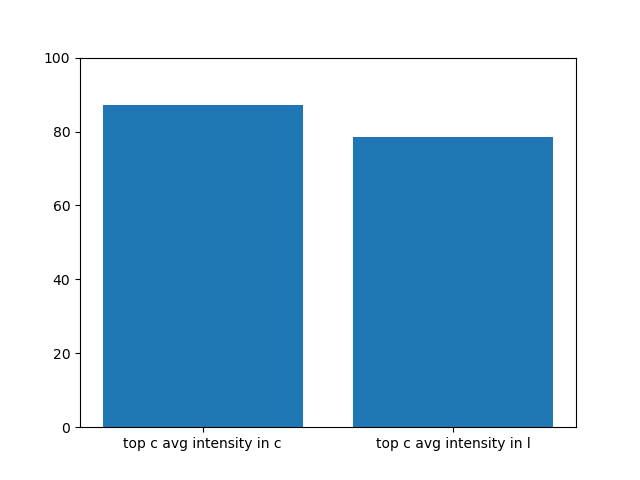

In [626]:
tmp = s12[s12.intensity_standarized>s12.intensity_standarized.quantile(0.95)]
plt.bar(['top c avg intensity in c', 'top c avg intensity in l'],
    [np.mean(tmp.intensity_standarized), np.mean(tmp.intensity1)])
plt.ylim(0,100)
plt.show()

(576, 5)
84.74198512793723 79.42688435019778


<IPython.core.display.Javascript object>


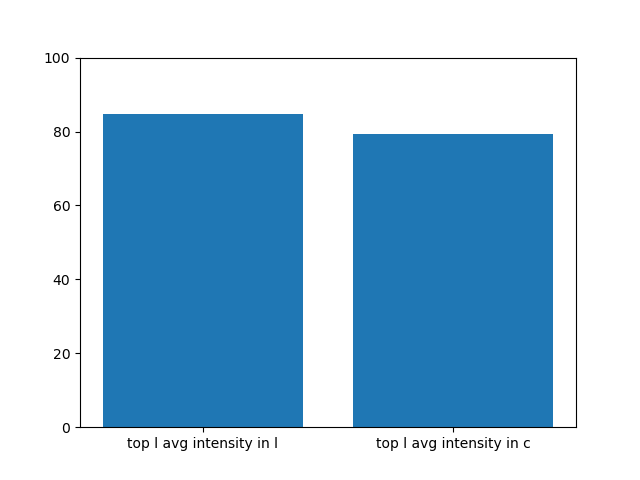

In [627]:
tmp = s21[s21.intensity_standarized>s21.intensity_standarized.quantile(0.95)]
print(tmp.shape)
plt.bar(['top l avg intensity in l', 'top l avg intensity in c'],
    [np.mean(tmp.intensity_standarized), np.mean(tmp.intensity2)])
print(np.mean(tmp.intensity_standarized), np.mean(tmp.intensity2))
plt.ylim(0,100)
plt.show()

(576, 5)
84.74198512793723 74.41400350489975


<IPython.core.display.Javascript object>


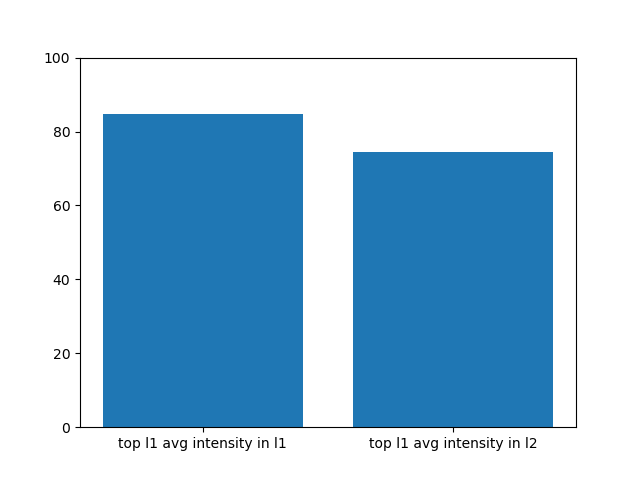

In [628]:
tmp = s23[s23.intensity_standarized>s23.intensity_standarized.quantile(0.95)]
print(tmp.shape)
plt.bar(['top l1 avg intensity in l1', 'top l1 avg intensity in l2'],
    [np.mean(tmp.intensity_standarized), np.mean(tmp.intensity2)])
print(np.mean(tmp.intensity_standarized), np.mean(tmp.intensity2))
plt.ylim(0,100)
plt.show()

<IPython.core.display.Javascript object>


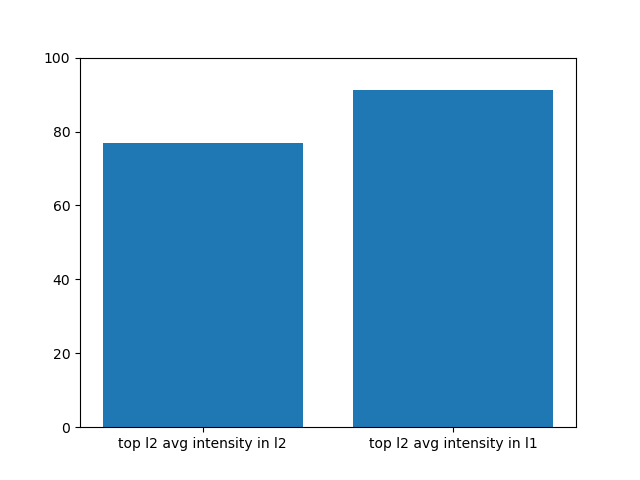

In [629]:
tmp = s32[s32.intensity_standarized>s32.intensity_standarized.quantile(0.95)]
plt.bar(['top l2 avg intensity in l2', 'top l2 avg intensity in l1'],
    [np.mean(tmp.intensity_standarized), np.mean(tmp.intensity2)])
plt.ylim(0,100)
plt.show()

In [592]:
for mouse in [10]:
    for region in [1]:
        df_array={}
        img_array={}
        for i in [0]:#range(len(session_order)):
            df_array[i] = pd.read_csv(dir_path + cell_data_fn_template
                                      .format(mouse, region, ctx_session_order[i]), "\t", header=1)
            img_array[i] =  io.imread(dir_path + img_fn_template
                                      .format(mouse, region, ctx_session_order[i])).astype("uint8")
            df_array[i] = df_array[i][df_array[i]['Interior (px)']>30]
            df_array[i] = update_intensity_for_df(df_array[i], img_array[i])
            

<IPython.core.display.Javascript object>


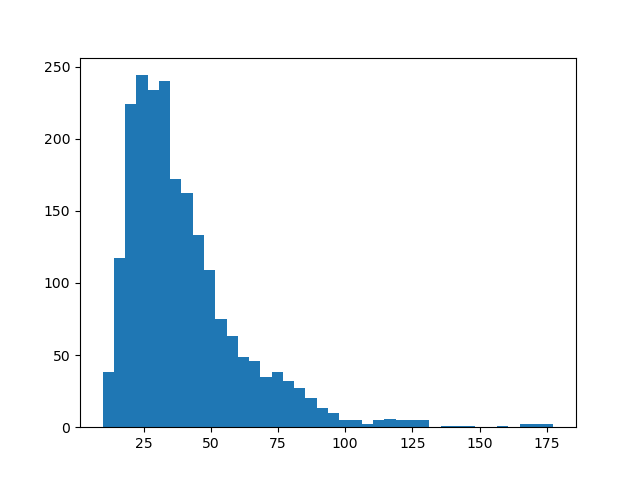

In [596]:
plt.hist(df_array[0].intensity_standarized,40)
plt.show()